<h2>
<i>ETF Rotation</i>
</h2>
<h3>
by</br>
Ian Kaplan</br>
</h3>

<p>
This Jupyter notebook is saved on GitHub: https://github.com/IanLKaplan/twelve_percent
</p>
<p>
The approach to investment return and risk varies with the investor and their stage
in life.  A prudent investor that
does not need to access their investments for twenty years might be willing to accept
higher risk in return for higher long term gains. A prudent investor who is near or at
retirement age would have much less tolerance for risk.
</p>
<p>
The Holy Grail of investing would be market (e.g., S&P 500) returns or better with
much less risk (like the Holy Grail, this is generally unattainable).
</p>
<p>
This Jupyter notebook investigates a stock market trading algorithm that is often referred
to as ETF rotation. The ETF rotation algorithm has less risk
and, in some cases, better returns than a "buy and hold" algorithm (see
<a href="https://github.com/IanLKaplan/all_weather_portfolio/blob/master/all_weather_portfolio.ipynb">All Weather" Portfolios</a>)
For example, the ETF rotation algorithm described in this notebook had higher
returns with less risk than the S&P 500 for
a portfolio investment that started in 2008 to 2019. After 2019 the return of the
ETF rotation portfolio was equal or less than the S&P 500.
</p>
<p>
I first learned about the ETF rotation algorithm in the
(short) book <i>The 12% Solution: Earn A 12% Average Annual Return On Your Money, Beating
The S&P 500</i> by David Alan Carter.  According to David Alan Carter, the outlined
ETF rotation algorithm yields a 12% return, on average. The time period in the
 book ends in December 2017.
</p>
<p>
The analysis in <i>The 12% Solution</i> was done with on-line tools like those
from <a href="ETFReplay.com">ETFReplay.com</a> and
<a href="stockcharts.com">stockcharts.com</a>.  The promise of these on-line tools
is that anyone can investigate investment strategies without having to
develop custom software in Python or R. On-line tools are generally "black boxes"
and the user must trust that the on-line tool is properly simulating the
desired portfolio strategy.
</p>
<p>
Following the ETF rotation algorithm outlined in <i>The 12% Solution</i>,
the reader trades one of four equity ETFs or a cash ETF and one of two bond ETFs.
The <i>The 12% Solution</i> suggests that this analysis can be done
using on-line tools.
</p>
<p>
<i>The 12% Solution</i> portfolio allocates 60% of the portfolio to equity (stock) ETFs
and 40% in bonds.  The 60% equity/40% bond investment portfolio allocation is
often recommended for lower risk investment portfolios.
</p>
<p>
The ETF rotation algorithm outlined in <i>The 12% solution</i> is sometimes referred
 to as a momentum algorithm. For the equity portion or bond portion of the
 portfolio, an ETF with the highest previous three month return is selected
 from the equity or bond ETF sets. This ETF is held for one month before
 selecting another ETF (which may be the same as the current ETF). The portfolio
 is rebalanced every month, so 60% is always allocated to the equity ETF set
 (or SHY) and 40% is allocated to the bond set.
  </p>
 <p>
 The momentum algorithm is based on the premise that the return of
 an ETF in the current month is predicted by the past three month return.
 As we shall see later, a quantitative analysis
 of this momentum algorithm is difficult because of the limited data set and the
 resultant error.
</p>
<p>
As we can see in the case of the 2008 financial crash, the ETF rotation algorithm will shift
assets out of stocks into cash and bonds. Note that this does not work for rapid
market crashes like the 2020 COVID-19 market crash.
</p>
<p>
The bond portion of the portfolio is allocated to either a US Treasury bond
ETF or to a corporate high yield (sometimes called junk bonds) ETF, depending on the
relative yield over the previous three months.
</p>
<p>
In this Jupyter notebook I have tried to reproduce the results described in
<i>The 12% solution</i>. The results in this notebook do not match the results
in <i>The 12% solution</i>. The results in <i>The 12% Solution</i> show higher
return than those calculated in this notebook.  I have tried to find the reasons
for the difference in portfolio returns calculated here and in <i>The 12% Solution</i>,
but I have not succeeded.
</p>

<h2>
The ETF Rotation Set
</h2>
<h3>
Equity ETFs
</h3>
<p>
In <i>The 12% Solution</i> there are four ETFs that are used in rotation, two bond funds
and one ETF (SHY) that is used as a proxy for "cash" (e.g., an asset at the risk free rate).
</p>
<ul>
<li>
<p>
IWM: iShares Russell 2000 ETF
</p>
<p>
IWM tracks a market-cap-weighted index of US small-cap stocks. The index selects
stocks ranked 1,001-3,000 by market cap.
</p>
<p>
Inception date: 5/22/2000
</p>
</li>
<li>
<p>
MDY: SPDR S&P Midcap 400 ETF Trust
</p>
<p>
MDY tracks a market-cap-weighted index of midcap US companies.
</p>
<p>
Inception date: 5/04/1995
</p>
</li>
<li>
<p>
QQQ: Invesco QQQ Trust
</p>
<p>
QQQ tracks a modified-market-cap-weighted index of 100 NASDAQ-listed stocks.
</p>
<p>
Inception date: 3/10/1999
</p>
</li>
<li>
<p>
SPY: SPDR S&P 500 ETF Trust
</p>
<p>
SPY tracks a market-cap-weighted index of US large- and midcap stocks selected by
the S&P Committee (e.g., S&P 500).
</p>
<p>
Inception date: Jan 22, 1993
</p>
</li>
</ul>
<h3>
Bond ETFs
</h3>
<ul>
<li>
<p>
TLT: iShares 20+ Year Treasury Bond ETF
</p>
<p>
TLT tracks a market-weighted index of debt issued by the US Treasury
with remaining maturities of 20 years or more.
</p>
<p>
Inception date: 7/22/2002
</p>
</li>
<li>
<p>
JNK: SPDR Bloomberg High Yield Bond ETF
</p>
<p>
JNK tracks a market-weighted index of highly liquid, high-yield, US
dollar-denominated corporate bonds.
</p>
<p>
Inception date: 11/28/2007
</p>
</li>
</ul>
<h3>
Cash Proxy
</h3>
<ul>
<li>
<p>
SHY: iShares 10-20 Year Treasury Bond ETF
</p>
<p>
SHY tracks a market weighted index of debt issued by the US Treasury
with 1-3 years remaining to maturity. Treasury STRIPS are excluded.
</p>
<p>
Inception date: 07/22/2002
</p>
</li>
</ul>
<p>
In <i>The 12% Solution</i> the backtest time period starts January 2008.
The inception period for the JNK corporate high yield bond fund is
November 18, 2007.  To simplify the software in this notebook, the start period is
March 3, 2008 (providing a look-back period over December 2007, January 2008 and
February 2008).
</p>

In [712]:
from datetime import datetime, timedelta
from numpy import sqrt
from tabulate import tabulate
from typing import List, Tuple
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.indexes.datetimes import DatetimeIndex
from dateutil.relativedelta import relativedelta
import numpy as np
from pathlib import Path
import tempfile
from IPython.display import Image

plt.style.use('seaborn-whitegrid')
pd.options.mode.chained_assignment = 'raise'

def get_market_data(file_name: str,
                    data_col: str,
                    symbols: List,
                    data_source: str,
                    start_date: datetime,
                    end_date: datetime) -> pd.DataFrame:
    """
      file_name: the file name in the temp directory that will be used to store the data
      data_col: the type of data - 'Adj Close', 'Close', 'High', 'Low', 'Open', Volume'
      symbols: a list of symbols to fetch data for
      data_source: yahoo, etc...
      start_date: the start date for the time series
      end_date: the end data for the time series
      Returns: a Pandas DataFrame containing the data.

      If a file of market data does not already exist in the temporary directory, fetch it from the
      data_source.
    """
    temp_root: str = tempfile.gettempdir() + '/'
    file_path: str = temp_root + file_name
    temp_file_path = Path(file_path)
    file_size = 0
    if temp_file_path.exists():
        file_size = temp_file_path.stat().st_size

    if file_size > 0:
        close_data = pd.read_csv(file_path, index_col='Date')
    else:
        panel_data: pd.DataFrame = data.DataReader(symbols, data_source, start_date, end_date)
        close_data: pd.DataFrame = panel_data[data_col]
        close_data.to_csv(file_path)
    assert len(close_data) > 0, f'Error reading data for {symbols}'
    return close_data


equity_etfs = ['IWM', 'MDY', 'QQQ', 'SPY']
bond_etfs = ['JNK', 'TLT']
cash_etf = 'SHY'

data_source = 'yahoo'
# The start date is the date used in the examples in The 12% Solution
# yyyy-mm-dd
start_date_str = '2008-03-03'
start_date: datetime = datetime.fromisoformat(start_date_str)
look_back_date_str = '2007-12-03'
look_back_date: datetime = datetime.fromisoformat(look_back_date_str)
end_date: datetime = datetime.today() - timedelta(days=1)
# get rid of any time component
end_date = datetime(end_date.year, end_date.month, end_date.day)

d2019_start = datetime.fromisoformat("2019-01-02")
d2019_end = datetime.fromisoformat("2019-12-31")


etf_adjclose_file = 'equity_etf_adjclose'
equity_adj_close = get_market_data(file_name=etf_adjclose_file,
                                data_col='Adj Close',
                                symbols=equity_etfs,
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

shy_adjclose_file = 'shy_adjclose'
shy_adj_close = get_market_data(file_name=shy_adjclose_file,
                                data_col='Adj Close',
                                symbols=[cash_etf],
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

fixed_income_adjclose_file = "fixed_income_adjclose"
fixed_income_adjclose = get_market_data(file_name=fixed_income_adjclose_file,
                                data_col='Adj Close',
                                symbols=bond_etfs,
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

# 13-week yearly treasury bond quote
risk_free_asset = '^IRX'
rf_file_name = 'rf_adj_close'
# The bond return is reported as a yearly return percentage
rf_adj_close = get_market_data(file_name=rf_file_name,
                                data_col='Adj Close',
                                symbols=[risk_free_asset],
                                data_source=data_source,
                                start_date=start_date,
                                end_date=end_date)

# The ^IRX interest rate is reported as a yearly percentage rate.
# Convert this to a daily interest rate
rf_adj_rate_np: np.array = np.array( rf_adj_close.values ) / 100
rf_daily_np = ((1 + rf_adj_rate_np) ** (1/360)) - 1
rf_daily_df: pd.DataFrame = pd.DataFrame( rf_daily_np, index=rf_adj_close.index, columns=['^IRX'])

corr_mat = round(equity_adj_close.corr(), 3)



<h3>
ETF Correlation
</h3>
<p>
In <i>The 12% Solution</i> ETF rotation, the ETF with the highest return in the
previous three months is selected, unless the return is less than the return of
SHY, in which case SHY is selected.
</p>
<p>
An important point to note is that the equity ETFs in the <i>The 12% Solution</i>
set are highly correlated. One ETF may do somewhat better than another, but they are all
market ETFs and have similar performance.  If the "market" is down
then all of the ETFs will probably be down.
</p>
<p>
The correlation matrix below shows the correlation between the equity ETFs.
</p>

In [713]:
print(tabulate(corr_mat, headers=[*corr_mat.columns], tablefmt='fancy_grid'))

╒═════╤═══════╤═══════╤═══════╤═══════╕
│     │   IWM │   MDY │   QQQ │   SPY │
╞═════╪═══════╪═══════╪═══════╪═══════╡
│ IWM │ 1     │ 0.997 │ 0.953 │ 0.981 │
├─────┼───────┼───────┼───────┼───────┤
│ MDY │ 0.997 │ 1     │ 0.955 │ 0.986 │
├─────┼───────┼───────┼───────┼───────┤
│ QQQ │ 0.953 │ 0.955 │ 1     │ 0.988 │
├─────┼───────┼───────┼───────┼───────┤
│ SPY │ 0.981 │ 0.986 │ 0.988 │ 1     │
╘═════╧═══════╧═══════╧═══════╧═══════╛


<p>
The high correlation between the ETFs suggests two areas that are worth investigating:
</p>
<ul>
<li>
<p>
Would the financial performance be similar if only a single ETF were used. For example,
SPY?
</p>
</li>
<li>
<p>
If a larger ETF universe is used, ETFs with lower correlation might be selected
resulting in better performance.
</p>
</li>
</ul>

<h3>
Asset return over time
</h3>

<p>
The return calculations in this notebook use simple return. The simple return for
a time period <i>t</i> is:
</p>

$\ R_t = \large \frac{R_t - R_{t-1}}{R_{t-1}} = \frac{R_t}{R_{t-1}} - 1$

The portfolio value calculated via continuously compounded returns is:

$\ portfolio\ value\ = V_t = V_{t-1} + V_{t-1} \times R_{t} $

where $\ V_{0} = initial\ investment $

In [714]:

def convert_date(some_date):
    if type(some_date) == str:
        some_date = datetime.fromisoformat(some_date)
    elif type(some_date) == np.datetime64:
        ts = (some_date - np.datetime64('1970-01-01T00:00')) / np.timedelta64(1, 's')
        some_date = datetime.utcfromtimestamp(ts)
    return some_date


def findDateIndex(date_index: DatetimeIndex, search_date: datetime) -> int:
    '''
    In a DatetimeIndex, find the index of the date that is nearest to search_date.
    This date will either be equal to search_date or the next date that is less than
    search_date
    '''
    index: int = -1
    i = 0
    search_date = convert_date(search_date)
    date_t = datetime.today()
    for i in range(0, len(date_index)):
        date_t = convert_date(date_index[i])
        if date_t >= search_date:
            break
    if date_t > search_date:
        index = i - 1
    else:
        index = i
    return index

# A unit test for findDateIndex, which is a function that is used throughout the code.
test_date_index = DatetimeIndex(['2007-12-03', '2007-12-04', '2007-12-05', '2007-12-06', '2007-12-07',
                   '2007-12-10', '2007-12-11', '2007-12-12', '2007-12-13', '2007-12-14',
                   '2007-12-15', '2007-12-18', '2007-12-19'])

assert findDateIndex(test_date_index, datetime.fromisoformat('2007-12-03')) == 0
assert findDateIndex(test_date_index, datetime.fromisoformat('2007-12-09')) == 4
assert findDateIndex(test_date_index, datetime.fromisoformat('2007-12-14')) == 9
assert findDateIndex(test_date_index, datetime.fromisoformat('2007-12-17')) == 10
assert findDateIndex(test_date_index, datetime.fromisoformat('2007-12-20')) == 12


asset_adj_close = equity_adj_close.copy()
asset_adj_close[shy_adj_close.columns[0]] = shy_adj_close

start_date_ix = findDateIndex(asset_adj_close.index, start_date)

assert start_date_ix >= 0


def chooseAssetName(start: int, end: int, asset_set: pd.DataFrame) -> str:
    '''
    Choose an ETF asset or cash for a particular range of close price values.
    The ETF and cash time series should be contained in a single DataFrame
    The function returns a DataFrame with the highest returning asset for the
    period.
    '''
    asset_columns = asset_set.columns
    asset_name = asset_columns[0]
    if len(asset_columns) > 1:
        ret_list = []
        start_date = asset_set.index[start]
        end_date = asset_set.index[end]
        for asset in asset_set.columns:
            ts = asset_set[asset][start:end+1]
            start_val = ts[0]
            end_val = ts[-1]
            r = (end_val/start_val) - 1
            ret_list.append(r)
        ret_df = pd.DataFrame(ret_list).transpose()
        ret_df.columns = asset_set.columns
        ret_df = round(ret_df, 3)
        column = ret_df.idxmax(axis=1)[0]
        asset_name = column
    return asset_name



<h3>
Start Period
</h3>

<p>
The ETF rotation set for 60% of the portfolio is composed of the equity ETFs and SHY.
</p>

<p>
<i>The 12% Solution</i> ETF rebalancing algorithm picks the ETF with the highest
three month return or SHY (the proxy for cash).  The starting date is the first trading
day in March 2008, March 3, 2008. The start of the look-back period is December 1, 2007.
</p>
The stock part of the portfolio (60%) is invested
in the chosen asset for the next month and the portfolio is rebalanced again.
</p>
<p>
The 40% of the portfolio that is held in bonds is invested in either TLT (the Treasury
ETF) or JNK (the high yield corporate bond ETF).
</p>
<p>
To check that the code is picking the right asset, we can look at the plot showing
the percentage return for each of the assets.
</p>

The asset for the first three month period will be SHY


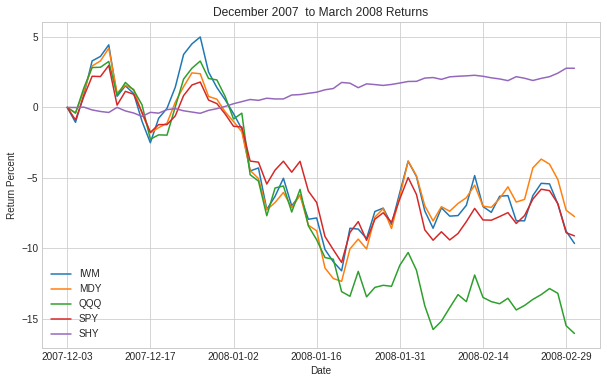

In [715]:
def percent_return_df(start_date: datetime, end_date: datetime, prices_df: pd.DataFrame) -> pd.DataFrame:
    def percent_return(time_series: pd.Series) -> pd.Series:
        return list(((time_series[i] / time_series[0]) - 1.0 for i in range(0, len(time_series))))


    date_index = prices_df.index
    start_ix = findDateIndex(date_index, start_date)
    end_ix = findDateIndex(date_index, end_date)
    period_df = prices_df[:][start_ix:end_ix+1]
    period_return_df = pd.DataFrame()
    for col in period_df.columns:
        return_series = percent_return(period_df[col])
        period_return_df[col] = return_series
    period_return_df.index = period_df.index
    return_percent_df = round(period_return_df * 100, 2)
    return return_percent_df

quarter_return_df = percent_return_df(start_date=look_back_date, end_date=start_date, prices_df=asset_adj_close)

ax = quarter_return_df.plot(grid=True, title='December 2007  to March 2008 Returns', figsize=(10,6))
ax.set_ylabel('Return Percent')

start_date_ix = findDateIndex(asset_adj_close.index, start_date)
asset_name = chooseAssetName(0, start_date_ix, asset_adj_close)

print(f'The asset for the first three month period will be {asset_name}')

<h3>
ETF Rotation Algorithm
</h3>

<ol>
<li>
Create a DataFrame that constains adjusted close price for the the ETF universe and the
cash ETF (SHY). This will be referred to as the asset DataFrame
</li>
<li>
Create a DataFrame that contains the adjusted close price for the bond ETF
universe. This will either be TLT or TLT and JNK.
</li>
<li>
<p>
Choose a start date that has three trading months of past data.
</p>
<p>
From the start date to the current date, stepping by one trading month
</p>
<ol>
<li>
Choose the asset with the highest return over the past three trading months
from the asset DataFrame (e.g., an equity or the cash ETF).
</li>
<li>
Choose the bond asset with the highest return over the past three trading
months from the bond DataFrame.
</li>
<li>
Calculate the daily return for the selected asset for one month forward from the start date.
</li>
<li>
Calculate the daily return for one month forward from the start date for the bond asset.
</li>
<li>
Apply the asset return to 60% of the current portfolio forward for one trading month
</li>
<li>
Apply the bond return to 40% of the current portfolio forward for one trading month
</li>
<li>
Add the two portfolio components to produce the total portfolio value for the month
</li>
<li>
Concatenate the current portfolio total to the portfolio total series that
will be used to plot the portfolio performance.
</li>
</ol>
<li>
Move the start date forward by one month of trading days
</li>
</li>
</ol>
<p>
The result will be the portfolio total as a DataFrame (with a date index).
</p>

In [716]:
def simple_return(time_series: np.array, period: int = 1) -> List :
    return list(((time_series[i]/time_series[i-period]) - 1.0 for i in range(period, len(time_series), period)))


def return_df(time_series_df: pd.DataFrame) -> pd.DataFrame:
    r_df: pd.DataFrame = pd.DataFrame()
    time_series_a: np.array = time_series_df.values
    return_l = simple_return(time_series_a, 1)
    r_df = pd.DataFrame(return_l)
    date_index = time_series_df.index
    r_df.index = date_index[1:len(date_index)]
    r_df.columns = time_series_df.columns
    return r_df


def apply_return(start_val: float, return_df: pd.DataFrame) -> np.array:
    port_a: np.array = np.zeros( return_df.shape[0] + 1)
    port_a[0] = start_val
    return_a = return_df.values
    for i in range(1, len(port_a)):
        port_a[i] = port_a[i-1] + port_a[i-1] * return_a[i-1]
    return port_a


def find_month_periods(start_date: datetime, end_date:datetime, data: pd.DataFrame) -> pd.DataFrame:
    start_date = convert_date(start_date)
    end_date = convert_date(end_date)
    date_index = data.index
    start_ix = findDateIndex(date_index, start_date)
    end_ix = findDateIndex(date_index, end_date)
    start_l = list()
    end_l = list()
    cur_month = start_date.month
    start_l.append(start_ix)
    i = 0
    for i in range(start_ix, end_ix+1):
        date_i = convert_date(date_index[i])
        if date_i.month != cur_month:
            end_l.append(i-1)
            start_l.append(i)
            cur_month = date_i.month
    end_l.append(i)
    # if there is note something like a full month period, remove the last period
    if end_l[-1] - start_l[-1] < 18:
        end_l.pop()
        start_l.pop()
    start_df = pd.DataFrame(start_l)
    end_df = pd.DataFrame(end_l)
    start_date_df = pd.DataFrame(date_index[start_l])
    end_date_df = pd.DataFrame(date_index[end_l])
    periods_df = pd.concat([start_df, start_date_df, end_df, end_date_df], axis=1)
    periods_df.columns = ['start_ix', 'start_date', 'end_ix', 'end_date']
    return periods_df


def portfolio_return(holdings: float,
                     asset_percent: float,
                     bond_percent: float,
                     asset_etfs: pd.DataFrame,
                     bond_etfs: pd.DataFrame,
                     start_date: datetime,
                     end_date: datetime) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    An implementation of the 12% Solution ETF rotation. From start_date to end_date
    the code calculates the highest past three month return from the asset_etfs and bond_etfs. The
    ETF with the highest return is selected for the next month.

    Calculate the monthly period from start_date to end_date. This will provide the monthly periods
    for the calculation.

    The daily returns are calculated for the next month and applied to the current portfolio balance.
    Then the loop steps forward by one month.
    """
    assert asset_etfs.shape[0] == bond_etfs.shape[0]
    periods_df = find_month_periods(start_date, end_date, asset_etfs)
    date_index = asset_etfs.index
    bond_asset_l = list()
    equity_asset_l = list()
    month_index_l = list()
    portfolio_a = np.zeros(0)
    for row in range(periods_df.shape[0]):
        asset_holdings = holdings * asset_percent
        bond_holdings = holdings * bond_percent
        period_info = periods_df[:][row:row+1]
        month_start_date = convert_date(period_info['start_date'].values[0])
        month_start_ix = period_info['start_ix'].values[0]
        month_end_ix = period_info['end_ix'].values[0]
        back_start_ix = (month_start_ix - trading_quarter) if (month_start_ix - trading_quarter) >= 0 else 0
        equity_asset = chooseAssetName(start=back_start_ix, end=month_start_ix, asset_set=asset_etfs)
        bond_asset = chooseAssetName(start=back_start_ix, end=month_start_ix, asset_set=bond_etfs)
        equity_asset_l.append(equity_asset)
        bond_asset_l.append(bond_asset)
        month_index_l.append(month_start_date)
        asset_month_prices_df = pd.DataFrame(asset_etfs[equity_asset][month_start_ix:month_end_ix + 1])
        bond_month_prices_df = pd.DataFrame(bond_etfs[bond_asset][month_start_ix:month_end_ix + 1])
        asset_month_return_df = return_df(asset_month_prices_df)
        bond_month_return_df = return_df(bond_month_prices_df)
        asset_month_a = apply_return(asset_holdings, asset_month_return_df)
        bond_month_a = apply_return(bond_holdings, bond_month_return_df)
        portfolio_total_a = asset_month_a + bond_month_a
        holdings = portfolio_total_a[-1]
        portfolio_a = np.append(portfolio_a, portfolio_total_a)
    portfolio_df = pd.DataFrame(portfolio_a)
    portfolio_df.columns = ['portfolio']
    num_rows = periods_df.shape[0]
    first_row = periods_df[:][0:1]
    last_row = periods_df[:][num_rows - 1:num_rows]
    start_ix = first_row['start_ix'].values[0]
    end_ix = last_row['end_ix'].values[0]
    portfolio_index = date_index[start_ix:end_ix + 1]
    portfolio_df.index = portfolio_index
    choices_df = pd.DataFrame()
    choices_df['Equity'] = pd.DataFrame(equity_asset_l)
    choices_df['Bond'] = pd.DataFrame(bond_asset_l)
    choices_df.index = month_index_l
    return portfolio_df, choices_df


def portfolio_replay(holdings: float,
                     asset_percent: float,
                     bond_percent: float,
                     asset_etfs: pd.DataFrame,
                     bond_etfs: pd.DataFrame,
                     etf_selection: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the portfolio time series from a pre-defined set of ETFs (e.g., equity and bond)

    The etf_selection_df DataFrame has the following columns:
    start_ix  start_date  end_ix    end_date equity bond
    """
    assert asset_etfs.shape[0] == bond_etfs.shape[0]
    date_index = asset_etfs.index
    portfolio_a = np.zeros(0)
    for index, month_allocation in etf_selection.iterrows():
        asset_holdings = holdings * asset_percent
        bond_holdings = holdings * bond_percent
        month_start_ix = month_allocation['start_ix']
        month_end_ix = month_allocation['end_ix']
        equity_asset = month_allocation['equity']
        bond_asset = month_allocation['bond']
        asset_month_prices_df = pd.DataFrame(asset_etfs[equity_asset][month_start_ix:month_end_ix + 1])
        bond_month_prices_df = pd.DataFrame(bond_etfs[bond_asset][month_start_ix:month_end_ix + 1])
        asset_month_return_df = return_df(asset_month_prices_df)
        bond_month_return_df = return_df(bond_month_prices_df)
        asset_month_a = apply_return(asset_holdings, asset_month_return_df)
        bond_month_a = apply_return(bond_holdings, bond_month_return_df)
        portfolio_total_a = asset_month_a + bond_month_a
        holdings = portfolio_total_a[-1]
        portfolio_a = np.append(portfolio_a, portfolio_total_a)
    portfolio_df = pd.DataFrame(portfolio_a)
    portfolio_df.columns = ['portfolio']
    num_rows = etf_selection.shape[0]
    first_row = etf_selection[:][0:1]
    last_row = etf_selection[:][num_rows - 1:num_rows]
    start_ix = first_row['start_ix'].values[0]
    end_ix = last_row['end_ix'].values[0]
    portfolio_index = date_index[start_ix:end_ix+1]
    portfolio_df.index = portfolio_index
    return portfolio_df


holdings = 100000
equity_percent = 0.6
bond_percent = 0.4

tlt = pd.DataFrame(fixed_income_adjclose['TLT'])
portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=tlt,
                                              start_date=start_date,
                                              end_date=end_date)


def build_plot_data(holdings: float, portfolio_df: pd.DataFrame, spy_df: pd.DataFrame) -> pd.DataFrame:
    port_start_date = portfolio_df.index[0]
    port_start_date = convert_date(port_start_date)
    port_end_date = portfolio_df.index[-1]
    port_end_date = convert_date(port_end_date)
    spy_index = spy_df.index
    spy_start_ix = findDateIndex(spy_index, port_start_date)
    spy_end_ix = findDateIndex(spy_index, port_end_date)
    spy_df = pd.DataFrame(spy_df[:][spy_start_ix:spy_end_ix+1])
    spy_return = return_df(spy_df)
    spy_return_a = apply_return(start_val=holdings, return_df=spy_return)
    spy_port = pd.DataFrame(spy_return_a)
    spy_port.columns = ['SPY']
    spy_port.index = spy_df.index
    plot_df = portfolio_df.copy()
    plot_df['SPY'] = spy_port
    return plot_df


def adjust_time_series(ts_one_df: pd.DataFrame, ts_two_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Adjust two DataFrame time series with overlapping date indices so that they
    are the same length with the same date indices.
    """
    ts_one_index = pd.to_datetime(ts_one_df.index)
    ts_two_index = pd.to_datetime(ts_two_df.index)
        # filter the close prices
    matching_dates = ts_one_index.isin( ts_two_index )
    ts_one_adj = ts_one_df[matching_dates]
    # filter the rf_prices
    ts_one_index = pd.to_datetime(ts_one_adj.index)
    matching_dates = ts_two_index.isin(ts_one_index)
    ts_two_adj = ts_two_df[matching_dates]
    return ts_one_adj, ts_two_adj


#
# Test for build_plot_data to make sure that the SPY component is handled correctly.
#
spy_unadj = pd.DataFrame(asset_adj_close['SPY'])
start_ix = findDateIndex(spy_unadj.index, d2019_start)
end_ix = findDateIndex(spy_unadj.index, d2019_end)
start_val = spy_unadj[spy_unadj.columns[0]].values[start_ix]
spy_section = pd.DataFrame(spy_unadj[spy_unadj.columns[0]][start_ix:end_ix+1])
spy_section.columns = ['portfolio']
plot_df = build_plot_data(start_val, spy_section, spy_unadj)
portfolio_a = plot_df[plot_df.columns[0]].values
spy_a = plot_df[plot_df.columns[1]].values
assert all( np.round(portfolio_a, 2) == np.round(spy_a, 2) )
#
# End test
#

<h3>
Checking the Code for Portfolio Calculation
</h3>
<p>
The results in this notebook do not match the results shown in the book
<i>The 12% Solution</i> or on the author's website
<a href="https://www.trendlineprofits.com/">https://www.trendlineprofits.com</a>
I have tried to make sure that the differences are not a result of errors in this
notebook's code.
</p>
<p>
The plot below was generated by the portfolio calculation code using an equity
and bond set composed only of SPY for 2019.  The portfolio result should closely
match the result for SPY.
</p>

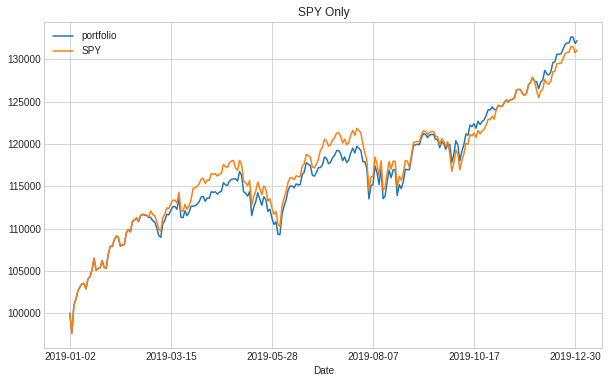

In [717]:
spyonly_df, t = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=spy_unadj,
                                              bond_etfs=spy_unadj,
                                              start_date=d2019_start,
                                              end_date=d2019_end)

plot_df = build_plot_data(holdings, spyonly_df, spy_unadj)
plot_df.plot(grid=True, title='SPY Only', figsize=(10,6))


spy_df = pd.DataFrame(equity_adj_close['SPY'])
spy_df, portfolio_df = adjust_time_series(spy_df, portfolio_df)
plot_df = build_plot_data(holdings, portfolio_df, spy_df)

<h3>
Portfolio Results (without bond rotation)
</h3>
<p>
In the book <i>The 12% Solution</i> the first example uses ETF rotation and a single
bond ETF, TLT (no bond rotation).
</p>

<p>
The plot below shows the results of the ETF rotation portfolio composed of 60% equity
ETFs (or SHY) and 40% TLT.
</p>
<p>
The author of <i>The 12% Solution</i> notes that the ETF rotation portfolio has better
performance than the S&P 500 (e.g., the SPY ETF) for a ten year period from 2008 to 2017.
This changes after 2019.
</p>

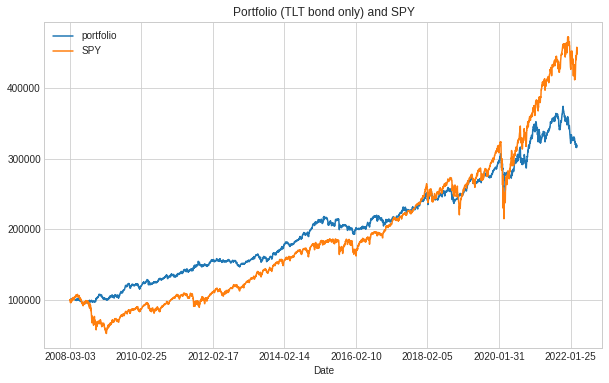

In [718]:
plot_df.plot(grid=True, title='Portfolio (TLT bond only) and SPY', figsize=(10,6))

trading_days = 252
trading_quarter = trading_days // 4

spy_return = return_df(spy_df)
port_return = return_df(portfolio_df)
spy_volatility = round(spy_return.values.std() * sqrt(trading_days) * 100, 2)
port_volatility = round(port_return.values.std() * sqrt(trading_days) * 100, 2)

vol_df = pd.DataFrame([port_volatility, spy_volatility])
vol_df.columns = ['Yearly Standard Deviation (percent)']
vol_df.index = ['Portfolio', 'SPY']

The volatility (risk) of the ETF selection portfolio is significantly less than the
SPY ETF which tracks the S&P 500.

In [719]:
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))


def excess_return_series(asset_return: pd.Series, risk_free: pd.Series) -> pd.DataFrame:
    excess_ret = asset_return.values.flatten() - risk_free.values.flatten()
    excess_ret_df = pd.DataFrame(excess_ret, index=asset_return.index)
    return excess_ret_df


def excess_return_df(asset_return: pd.DataFrame, risk_free: pd.Series) -> pd.DataFrame:
    excess_df: pd.DataFrame = pd.DataFrame()
    for col in asset_return.columns:
        e_df = excess_return_series(asset_return[col], risk_free)
        e_df.columns = [col]
        excess_df[col] = e_df
    return excess_df


def calc_sharpe_ratio(asset_return: pd.DataFrame, risk_free: pd.Series, period: int) -> pd.DataFrame:
    excess_return = excess_return_df(asset_return, risk_free)
    return_mean: List = []
    return_stddev: List = []
    for col in excess_return.columns:
        mu = np.mean(excess_return[col])
        std = np.std(excess_return[col])
        return_mean.append(mu)
        return_stddev.append(std)
    # daily Sharpe ratio
    # https://quant.stackexchange.com/questions/2260/how-to-annualize-sharpe-ratio
    sharpe_ratio = (np.asarray(return_mean) / np.asarray(return_stddev)) * np.sqrt(period)
    result_df: pd.DataFrame = pd.DataFrame(sharpe_ratio).transpose()
    result_df.columns = asset_return.columns
    ix = asset_return.index
    dateformat = '%Y-%m-%d'
    ix_start = ix[0]
    ix_start = convert_date(ix_start)
    ix_end = ix[len(ix)-1]
    ix_end = convert_date(ix_end)
    index_str = f'{ix_start} : {ix_end}'
    result_df.index = [ index_str ]
    return result_df


# Interest rates are quoted for the days when banks are open. The number of bank open days is less than
# the number of trading days. Adjust the portfolio_return series and the interest rate series so that they
# align.
rf_daily_adj, portfolio_return_adj = adjust_time_series(rf_daily_df, port_return)
spy_return_adj, t = adjust_time_series(spy_return, rf_daily_adj)

rf_daily_s = rf_daily_adj.squeeze()

portfolio_sharpe = calc_sharpe_ratio(portfolio_return_adj, rf_daily_s, trading_days)
spy_sharpe = calc_sharpe_ratio(spy_return_adj, rf_daily_s, trading_days)

sharpe_df = pd.concat([portfolio_sharpe, spy_sharpe], axis=1)

╒═══════════╤═══════════════════════════════════════╕
│           │   Yearly Standard Deviation (percent) │
╞═══════════╪═══════════════════════════════════════╡
│ Portfolio │                                  9.96 │
├───────────┼───────────────────────────────────────┤
│ SPY       │                                 20.49 │
╘═══════════╧═══════════════════════════════════════╛


<h3>
Sharpe Ratio
</h3>

<p>
The yearly Sharpe ratio for the ETF rotation portfolio (TLT bond only) and SPY is shown below.
</p>

In [720]:
print(tabulate(sharpe_df, headers=[*sharpe_df.columns], tablefmt='fancy_grid'))

╒═══════════════════════════════════════════╤═════════════╤══════════╕
│                                           │   portfolio │      SPY │
╞═══════════════════════════════════════════╪═════════════╪══════════╡
│ 2008-03-04 00:00:00 : 2022-03-31 00:00:00 │    0.843345 │ 0.604976 │
╘═══════════════════════════════════════════╧═════════════╧══════════╛


<h3>
Portfolio Return
</h3>

In [721]:
def period_return(portfolio_df: pd.DataFrame, period: int) -> pd.DataFrame:
    date_index = portfolio_df.index
    values_a = portfolio_df.values
    date_list = list()
    return_list = list()
    for i in range(period, len(values_a), period):
        r = (values_a[i]/values_a[i-period]) - 1
        d = date_index[i]
        return_list.append(r)
        date_list.append(d)
    return_df = pd.DataFrame(return_list)
    return_df.index = date_list
    return return_df


period_return_df = period_return(portfolio_df=portfolio_df, period=trading_days)
spy_period_return_df = period_return(portfolio_df=spy_df, period=trading_days)
portfolio_spy_return_df = pd.concat([period_return_df, spy_period_return_df], axis=1)
portfolio_spy_return_df.columns = ['ETF Rotation', 'SPY']
portfolio_spy_return_df = round(portfolio_spy_return_df * 100, 2)

<h3>
Percentage return for the ETF Rotation Portfolio and SPY
</h3>

In [722]:
print(tabulate(portfolio_spy_return_df, headers=[*portfolio_spy_return_df.columns], tablefmt='fancy_grid'))

average_return_df = pd.DataFrame(portfolio_spy_return_df.mean()).transpose()

╒════════════╤════════════════╤════════╕
│            │   ETF Rotation │    SPY │
╞════════════╪════════════════╪════════╡
│ 2009-03-03 │           0.45 │ -46.25 │
├────────────┼────────────────┼────────┤
│ 2010-03-03 │          20.35 │  63.98 │
├────────────┼────────────────┼────────┤
│ 2011-03-02 │          12.67 │  19.13 │
├────────────┼────────────────┼────────┤
│ 2012-03-01 │          13.72 │   7.17 │
├────────────┼────────────────┼────────┤
│ 2013-03-05 │           0.93 │  14.51 │
├────────────┼────────────────┼────────┤
│ 2014-03-05 │          16.52 │  24.14 │
├────────────┼────────────────┼────────┤
│ 2015-03-05 │          16.16 │  14.29 │
├────────────┼────────────────┼────────┤
│ 2016-03-04 │          -5.25 │  -2.8  │
├────────────┼────────────────┼────────┤
│ 2017-03-06 │           7.25 │  21.15 │
├────────────┼────────────────┼────────┤
│ 2018-03-06 │          16.27 │  17.03 │
├────────────┼────────────────┼────────┤
│ 2019-03-07 │           1.72 │   2.69 │
├────────────┼──

<h3>
Average Return (percent)
</h3>

In [723]:
print(tabulate(average_return_df, headers=[*average_return_df.columns], tablefmt='fancy_grid'))

╒════╤════════════════╤═════════╕
│    │   ETF Rotation │     SPY │
╞════╪════════════════╪═════════╡
│  0 │        9.14643 │ 13.3793 │
╘════╧════════════════╧═════════╛


<h3>
Rebalancing
</h3>

<p>
This portfolio starts out with 60% of the portfolio in equity ETFs or the cash ETF and
40% in one or more bond ETFs.  If the portfolio were not rebalanced, over time
the portion of the portfolio allocated to equity ETFs (and cash) would drift upward,
since equities usually have a higher return than bonds.
</p>
<p>
The portfolio is rebalanced monthly as each ETF is chosen.
In the <i><a href="https://github.com/IanLKaplan/all_weather_portfolio">All Weather Portfolio</a></i>
rebalancing the portfolio every year results in better portfolio results compared
to rebalancing monthly or quarterly.
</p>
<p>
In the case of the <i>12% Solution</i> portfolio, rebalancing yearly only resulted
in a small improvement in portfolio results.
</p>

In [724]:
portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=start_date,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, portfolio_df, spy_df)


<h3>
Adding in Bond Rotation
</h3>
<p>
The second example of ETF rotation in <i>The 12% Solution</i> adds bond rotation.
The 40% of the portfolio allocated to bonds is rotated between TLT and JNK (a
"high-yield" corporate bond ETF).  As with the equity ETFs, the bond ETF with the
highest return in the past three months is chosen for the current month.
</p>
<p>
In the case of the bond ETF rotation, the cash ETF SHY is not added to the bond
set (an example with SHY added to the bond set is explored later in the notebook).
</p>
<p>
The plot below shows the performance of the ETF rotation portfolio, with bond rotation
(TLT and JNK).
</p>

<AxesSubplot:title={'center':'Portfolio (TLT and JNK bond rotation) and SPY'}, xlabel='Date'>

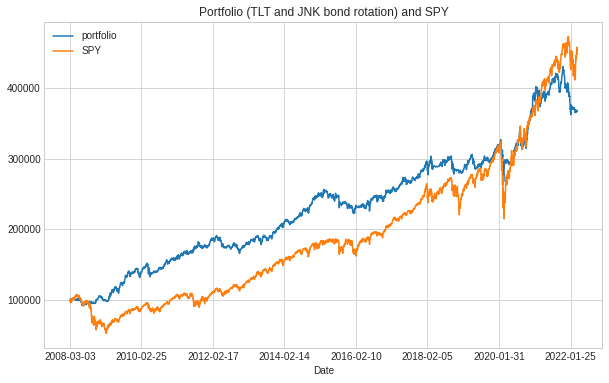

In [725]:
plot_df.plot(grid=True, title='Portfolio (TLT and JNK bond rotation) and SPY', figsize=(10,6))

<h3>
Standard Deviation and Sharpe Ratio
</h3>

<p>
The addition of bond ETF rotation slightly increased the standard deviation, which
resulted in a slight decrease in the Sharpe ratio.
</p>

In [726]:
port_return = return_df(portfolio_df)
port_volatility = round(port_return.values.std() * sqrt(trading_days) * 100, 2)

vol_df = pd.DataFrame([port_volatility, spy_volatility])
vol_df.columns = ['Yearly Standard Deviation (percent)']
vol_df.index = ['Portfolio', 'SPY']

<h4>
Yearly Standard Deviation (with bond rotation)
</h4>

In [727]:
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))

rf_daily_adj, portfolio_return_adj = adjust_time_series(rf_daily_df, port_return)
portfolio_sharpe = calc_sharpe_ratio(portfolio_return_adj, rf_daily_s, trading_days)
sharpe_df = pd.concat([portfolio_sharpe, spy_sharpe], axis=1)

╒═══════════╤═══════════════════════════════════════╕
│           │   Yearly Standard Deviation (percent) │
╞═══════════╪═══════════════════════════════════════╡
│ Portfolio │                                 11.15 │
├───────────┼───────────────────────────────────────┤
│ SPY       │                                 20.49 │
╘═══════════╧═══════════════════════════════════════╛


<h4>
Sharpe Ratio (with bond rotation)
</h4>

In [728]:
print(tabulate(sharpe_df, headers=[*sharpe_df.columns], tablefmt='fancy_grid'))

╒═══════════════════════════════════════════╤═════════════╤══════════╕
│                                           │   portfolio │      SPY │
╞═══════════════════════════════════════════╪═════════════╪══════════╡
│ 2008-03-04 00:00:00 : 2022-03-31 00:00:00 │    0.854415 │ 0.604976 │
╘═══════════════════════════════════════════╧═════════════╧══════════╛


<h3>
Portfolio Return with Bond Rotation
</h3>
<p>
Adding ETF rotation to the bond portion of the portfolio results in performance that is
close to the S&P 500 with half the volatility (risk).
</p>
<p>
The table below shows the yearly percentage returns for the portfolio without bond
ETF rotation, the portfolio with bond ETF rotation and SPY (S&P 500).
</p>

In [729]:
period_return_bond_df = period_return(portfolio_df=portfolio_df, period=trading_days)
portfolio_spy_return_df = pd.concat([period_return_df, period_return_bond_df, spy_period_return_df], axis=1)
portfolio_spy_return_df.columns = ['ETF Rotation','ETF w/bond rotation', 'SPY']
portfolio_spy_return_df = round(portfolio_spy_return_df * 100, 2)

print(tabulate(portfolio_spy_return_df, headers=[*portfolio_spy_return_df.columns], tablefmt='fancy_grid'))

average_return_df = pd.DataFrame(portfolio_spy_return_df.mean()).transpose()

╒════════════╤════════════════╤═══════════════════════╤════════╕
│            │   ETF Rotation │   ETF w/bond rotation │    SPY │
╞════════════╪════════════════╪═══════════════════════╪════════╡
│ 2009-03-03 │           0.45 │                 -1.57 │ -46.25 │
├────────────┼────────────────┼───────────────────────┼────────┤
│ 2010-03-03 │          20.35 │                 42.69 │  63.98 │
├────────────┼────────────────┼───────────────────────┼────────┤
│ 2011-03-02 │          12.67 │                 14.93 │  19.13 │
├────────────┼────────────────┼───────────────────────┼────────┤
│ 2012-03-01 │          13.72 │                 15.03 │   7.17 │
├────────────┼────────────────┼───────────────────────┼────────┤
│ 2013-03-05 │           0.93 │                 -1.97 │  14.51 │
├────────────┼────────────────┼───────────────────────┼────────┤
│ 2014-03-05 │          16.52 │                 17.68 │  24.14 │
├────────────┼────────────────┼───────────────────────┼────────┤
│ 2015-03-05 │          1

<h3>
Average Return (percent)
</h3>
<p>
The book <i>The 12% Solution</i> is named for the 12% average yearly return from the
ETF rotation portfolio that includes bond rotation. The average return in the notebook
is less than the average return reported in the book.
</p>
<p>
The time period in the book ends in 2017.  The book did not include the market
volatility from COVID and the Russian invasion of Ukraine.  As we can see in the
plots above, the ETF rotation algorithm out performs the S&P 500 until 2019,
when the S&P 500 begins to have a higher return.
</p>

In [730]:
print(tabulate(average_return_df, headers=[*average_return_df.columns], tablefmt='fancy_grid'))

╒════╤════════════════╤═══════════════════════╤═════════╕
│    │   ETF Rotation │   ETF w/bond rotation │     SPY │
╞════╪════════════════╪═══════════════════════╪═════════╡
│  0 │        9.14643 │                 10.51 │ 13.3793 │
╘════╧════════════════╧═══════════════════════╧═════════╛


<h3>
ETF Rotation from 2010 to present
</h3>
<p>
The author of <i>The 12% Solution</i>, David Alan Carter, points out that one of the best
ways to make money on the stock market is to avoid losses.  The ETF rotation algorithm
beats the S&P 500 (SPY) from 2008 to 2019.  This section looks at how much of
this performance is due to the fact that the 2008 market crash was avoided.
</p>

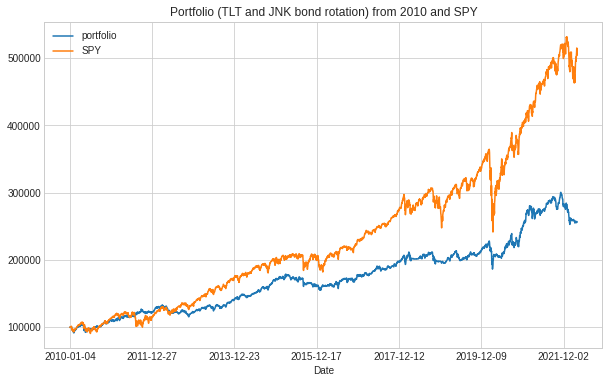

In [731]:
d2010_start: datetime = datetime.fromisoformat('2010-01-04')
d2010_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=d2010_start,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, d2010_portfolio_df, spy_df)

plot_df.plot(grid=True, title='Portfolio (TLT and JNK bond rotation) from 2010 and SPY', figsize=(10,6))

d2010_portfolio_df, d2010_spy_df = adjust_time_series(d2010_portfolio_df, spy_df)
period_return_df = period_return(portfolio_df=d2010_portfolio_df, period=trading_days)
spy_period_return_df = period_return(portfolio_df=d2010_spy_df, period=trading_days)
portfolio_spy_return_df = pd.concat([period_return_df, spy_period_return_df], axis=1)
portfolio_spy_return_df.columns = ['ETF Rotation', 'SPY']
portfolio_spy_return_df = round(portfolio_spy_return_df * 100, 2)

<h4>
Yearly Return
</h4>
<p>
The yearly returns are shown below
</p>

In [732]:
print(tabulate(portfolio_spy_return_df, headers=[*portfolio_spy_return_df], tablefmt='fancy_grid'))

d2010_port_return = return_df(d2010_portfolio_df)
d2010_spy_return = return_df(d2010_spy_df)
spy_volatility = round(d2010_spy_return.values.std() * sqrt(trading_days) * 100, 2)
port_volatility = round(d2010_port_return.values.std() * sqrt(trading_days) * 100, 2)

vol_df = pd.DataFrame([port_volatility, spy_volatility])
vol_df.columns = ['Yearly Standard Deviation (percent)']
vol_df.index = ['Portfolio', 'SPY']

╒════════════╤════════════════╤═══════╕
│            │   ETF Rotation │   SPY │
╞════════════╪════════════════╪═══════╡
│ 2011-01-03 │          10.38 │ 14.31 │
├────────────┼────────────────┼───────┤
│ 2012-01-03 │          11.78 │  2.46 │
├────────────┼────────────────┼───────┤
│ 2013-01-04 │          -0.05 │ 17.35 │
├────────────┼────────────────┼───────┤
│ 2014-01-06 │          15.65 │ 27.1  │
├────────────┼────────────────┼───────┤
│ 2015-01-06 │          19.57 │ 11.72 │
├────────────┼────────────────┼───────┤
│ 2016-01-06 │          -5.86 │  1.55 │
├────────────┼────────────────┼───────┤
│ 2017-01-05 │          10.36 │ 16.32 │
├────────────┼────────────────┼───────┤
│ 2018-01-05 │          13.9  │ 23.12 │
├────────────┼────────────────┼───────┤
│ 2019-01-08 │          -2.67 │ -4.31 │
├────────────┼────────────────┼───────┤
│ 2020-01-08 │          11.61 │ 28.75 │
├────────────┼────────────────┼───────┤
│ 2021-01-07 │          22.68 │ 19.03 │
├────────────┼────────────────┼───────┤


<h4>
Volatility
</h4>
<p>
The volatility of the ETF rotation portfolio is around two thirds of the S&P 500
volatility.
</p>

In [733]:
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))

╒═══════════╤═══════════════════════════════════════╕
│           │   Yearly Standard Deviation (percent) │
╞═══════════╪═══════════════════════════════════════╡
│ Portfolio │                                 10.76 │
├───────────┼───────────────────────────────────────┤
│ SPY       │                                 17.04 │
╘═══════════╧═══════════════════════════════════════╛


<h4>
Average Portfolio Return
</h4>

In [734]:
average_return_df = pd.DataFrame(portfolio_spy_return_df.mean()).transpose()
print(tabulate(average_return_df, headers=[*average_return_df.columns], tablefmt='fancy_grid'))

╒════╤════════════════╤═════════╕
│    │   ETF Rotation │     SPY │
╞════╪════════════════╪═════════╡
│  0 │           9.08 │ 15.2067 │
╘════╧════════════════╧═════════╛


<p>
Investment is always a balance between risk and reward. Investing in an ETF rotation
portfolio in 2010 has about sixty percent of the risk of the S&P 500. The average
return is also about sixty percent of the S&P 500.
</p>

<h2>
Notebook results and <i>12% Solution</i> Results
</h2>
<p>
The book <i>The 12% Solution</i> has an associated website
<a href="https://www.trendlineprofits.com/">
www.trendlineprofits.com</a> that is available free for people who purchased the book.
This website includes performance information on
<i>The 12% Solution</i> portfolio.  These results in the book and on the website do not
match the results calculated in this notebook.
</p>
<p>
In this section the plots calculated in this notebook and those from
trendlineprofits.com are shown.
</p>
<p>
In all cases the portfolio return reported on <i>trendlineprofits.com</i> is
higher than the portfolio returns calculated in this notebook.
</p>

In [735]:
five_year_start = datetime.fromisoformat("2017-01-03")
three_year_start = datetime.fromisoformat("2019-01-02")
one_year_start = datetime.fromisoformat("2021-01-04")
march_25_2022_end = datetime.fromisoformat("2022-03-25")

max_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=start_date,
                                              end_date=march_25_2022_end)

plot_max_df = build_plot_data(holdings, max_portfolio_df, spy_df)

five_year_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=five_year_start,
                                              end_date=march_25_2022_end)

plot_five_df = build_plot_data(holdings, five_year_portfolio_df, spy_df)

three_year_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=three_year_start,
                                              end_date=march_25_2022_end)

plot_three_df = build_plot_data(holdings, three_year_portfolio_df, spy_df)

one_year_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=one_year_start,
                                              end_date=march_25_2022_end)

plot_one_df = build_plot_data(holdings, one_year_portfolio_df, spy_df)

<h4>
2008 to March 25, 2022
</h4>

<AxesSubplot:title={'center':'ETF Rotation and SPY: 03/03/2008 - 03/25/2022'}, xlabel='Date'>

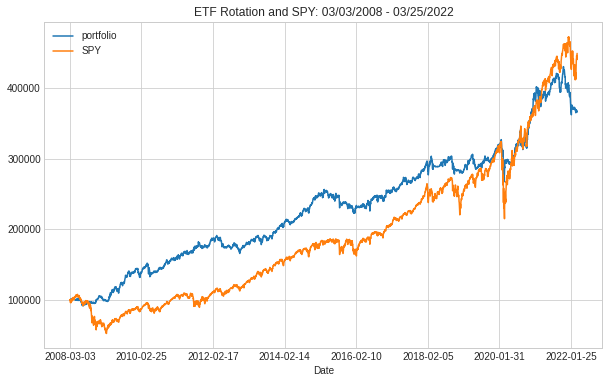

In [736]:
plot_max_df.plot(grid=True, title=f'ETF Rotation and SPY: {start_date.strftime("%m/%d/%Y")} - {march_25_2022_end.strftime("%m/%d/%Y")}', figsize=(10,6))
# Image(filename='images/the-12-total-return-2008-to-ytd-03-25-2022_orig.jpg')


<h4>
5 Years: 2017 to March 25, 2022
</h4>

<AxesSubplot:title={'center':'5-years: 01/03/2017 - 03/25/2022 and SPY'}, xlabel='Date'>

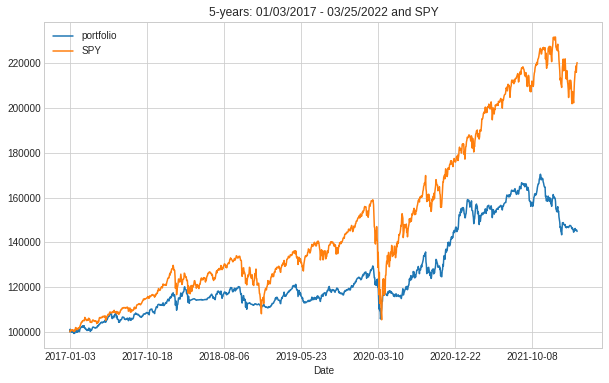

In [737]:
plot_five_df.plot(grid=True, title=f'5-years: {five_year_start.strftime("%m/%d/%Y")} - {march_25_2022_end.strftime("%m/%d/%Y")} and SPY', figsize=(10,6))
# Image(filename='images/the-12-total-return-2017-to-ytd-03-25-2022_orig.jpg')


<h4>
Three Years: 2019 to March 25, 2022
</h4>

<AxesSubplot:title={'center':'3-years: 01/02/2019 - 03/25/2022 and SPY'}, xlabel='Date'>

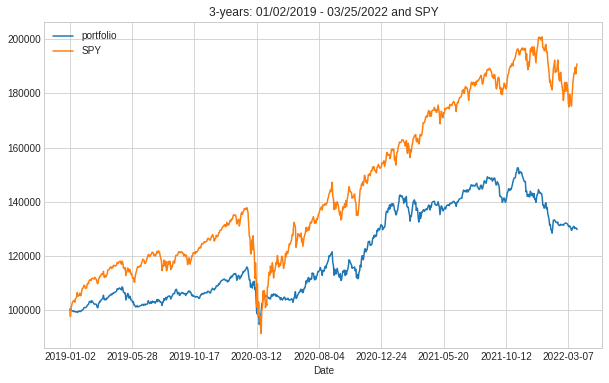

In [738]:
plot_three_df.plot(grid=True, title=f'3-years: {three_year_start.strftime("%m/%d/%Y")} - {march_25_2022_end.strftime("%m/%d/%Y")} and SPY', figsize=(10,6))
# Image(filename='images/the-12-total-return-2019-to-ytd-03-25-2022_orig.jpg')

<h4>
One Year: 2021 to March 25, 2022
</h4>

<AxesSubplot:title={'center':'1-year: 01/04/2021 - 03/25/2022 and SPY'}, xlabel='Date'>

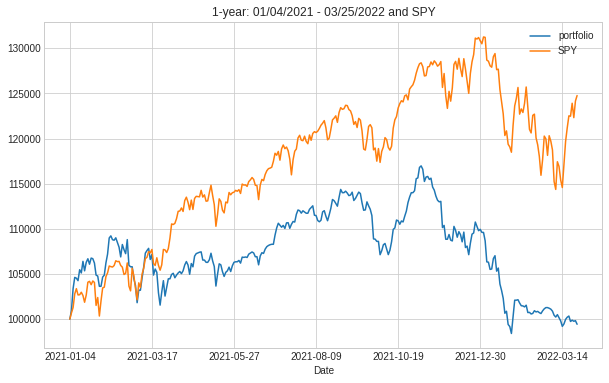

In [739]:
plot_one_df.plot(grid=True, title=f'1-year: {one_year_start.strftime("%m/%d/%Y")} - {march_25_2022_end.strftime("%m/%d/%Y")} and SPY', figsize=(10,6))
# Image(filename='images/the-12-total-return-2021-to-ytd-03-25-2022_orig.jpg')

<h3>
Difference Between Notebook and trendlineprofits.com
</h3>
<p>
The plot below shows the results for the ETF rotation portfolio (with bond rotation)
for 2019.
</p>

<AxesSubplot:title={'center':'2019: 01/02/2019 - 12/31/2019 and SPY'}, xlabel='Date'>

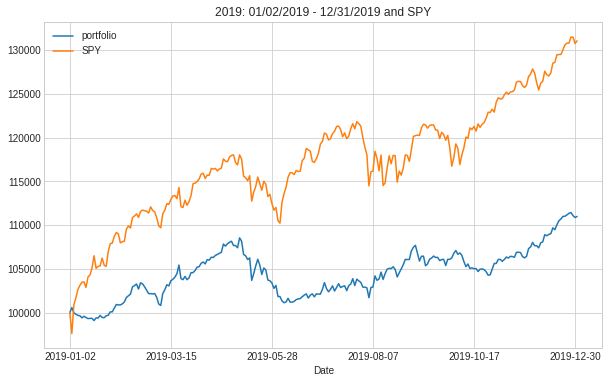

In [740]:
d2019_portfolio_df, d2019_assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=d2019_start,
                                              end_date=d2019_end)

plot_df = build_plot_data(holdings, d2019_portfolio_df, spy_df)
plot_df.plot(grid=True, title=f'2019: {d2019_start.strftime("%m/%d/%Y")} - {d2019_end.strftime("%m/%d/%Y")} and SPY', figsize=(10,6))


<p>
The portfolio return for an ETF set and a bond set that consists only of SPY
closely matches the return of SPY (see plot above). This provides evidence that
the portfolio calculation is performed accurately.
</p>
<p>
One source of difference is in the ETFs that are chosen for the past three
month period.
</p>

<h3>
2019 Assets
</h3>

<p>
Although there is overlap in the ETFs selected by the notebook code and
the trendlineprofits.com results, there are differences.  This section discusses
these differences.
</p>
<p>
To briefly review the ETF rotation algorithm:
</p>
<p>
An ETF is selected for the current month.  This is done by looking back over the past
three months and selecting the ETF with the highest return or SHY if SHY has
a higher return than the any of other ETFs.
</p>
<p>
The plots below show percentage returns for the lookback period.  The ETF that is
selected by the notebook code is listed in the plot title.  This is the ETF that
is used for the "current" month which starts at the end of the lookback period.
</p>
<p>
The ETF that is selected on the Trendline website for the period is
shown in the title. Only the plots where the Trendline and notebook selection differ
are shown.
</p>

In [741]:
trendline_assets = ['SHY', # 1
                    'QQQ', # 2
                    'QQQ', # 3
                    'QQQ', # 4
                    'QQQ', # 5
                    'QQQ', # 6
                    'SHY', # 7
                    'SPY', # 8
                    'QQQ', # 9
                    'SPY', # 10
                    'QQQ', # 11
                    'QQQ' # 12
                    ]

trendline_df = pd.DataFrame(trendline_assets)
trendline_df.index = d2019_assets_df.index
d2019_assets_df['trendline'] = trendline_df
d2019_assets_df.drop(d2019_assets_df.columns[1], inplace=True, axis=1)
print(tabulate(d2019_assets_df, headers=['Equity ETFs', 'Trendline ETFs'], tablefmt='fancy_grid'))


def display_asset_selection(month_start: str, prices_df: pd.DataFrame) -> None:
    date_index = prices_df.index
    look_back_end = datetime.fromisoformat(month_start)
    end_ix = findDateIndex(date_index, look_back_end)
    start_ix = (end_ix - trading_quarter) if (end_ix - trading_quarter) >= 0 else 0
    look_back_start = convert_date(date_index[start_ix])
    name = chooseAssetName(start_ix, end_ix, prices_df)
    period_return_df = percent_return_df(start_date=look_back_start,
                                         end_date=look_back_end,
                                         prices_df=prices_df)
    title_str =f'{look_back_start.strftime("%m/%d/%Y")} - {look_back_end.strftime("%m/%d/%Y")} asset {name}'
    ax = period_return_df.plot(grid=True, title=title_str, figsize=(10,6))
    ax.set_ylabel('Return Percent')


╒═════════════════════╤═══════════════╤══════════════════╕
│                     │ Equity ETFs   │ Trendline ETFs   │
╞═════════════════════╪═══════════════╪══════════════════╡
│ 2019-01-02 00:00:00 │ SHY           │ SHY              │
├─────────────────────┼───────────────┼──────────────────┤
│ 2019-02-01 00:00:00 │ MDY           │ QQQ              │
├─────────────────────┼───────────────┼──────────────────┤
│ 2019-03-01 00:00:00 │ QQQ           │ QQQ              │
├─────────────────────┼───────────────┼──────────────────┤
│ 2019-04-01 00:00:00 │ QQQ           │ QQQ              │
├─────────────────────┼───────────────┼──────────────────┤
│ 2019-05-01 00:00:00 │ QQQ           │ QQQ              │
├─────────────────────┼───────────────┼──────────────────┤
│ 2019-06-03 00:00:00 │ SHY           │ QQQ              │
├─────────────────────┼───────────────┼──────────────────┤
│ 2019-07-01 00:00:00 │ QQQ           │ SHY              │
├─────────────────────┼───────────────┼─────────────────

<h4>
Trendline selects QQQ for the three month period ending 2019-02-01
</h4>
<p>
It's very close...
</p>

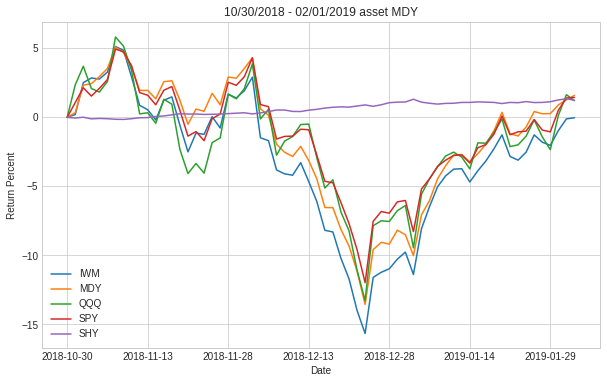

In [742]:
display_asset_selection('2019-02-01', asset_adj_close)


<h4>
Trendline selects QQQ
</h4>

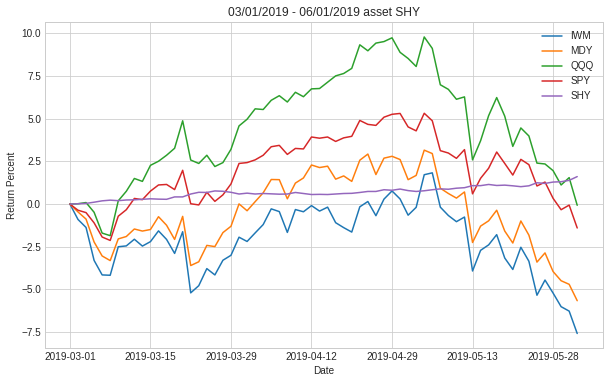

In [743]:
display_asset_selection('2019-06-01', asset_adj_close)

<h4>
Trendline selects SHY
</h4>

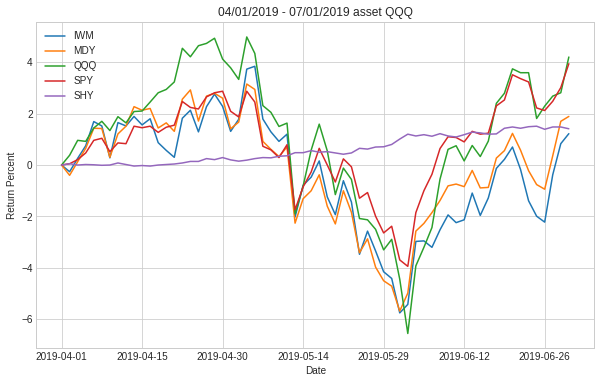

In [744]:
display_asset_selection('2019-07-01', asset_adj_close)

<h4>
Trendline selects SHY
</h4>

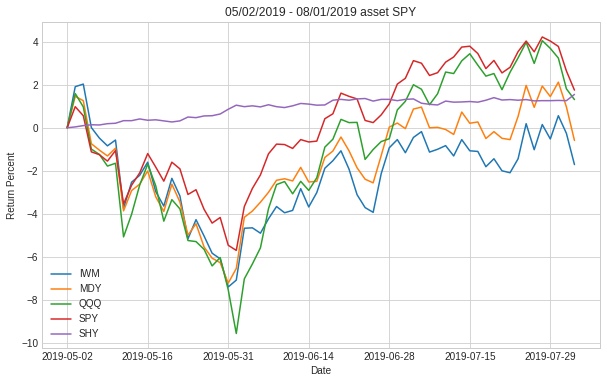

In [745]:
display_asset_selection('2019-08-01', asset_adj_close)



<h4>
Trendline selects SPY
</h4>

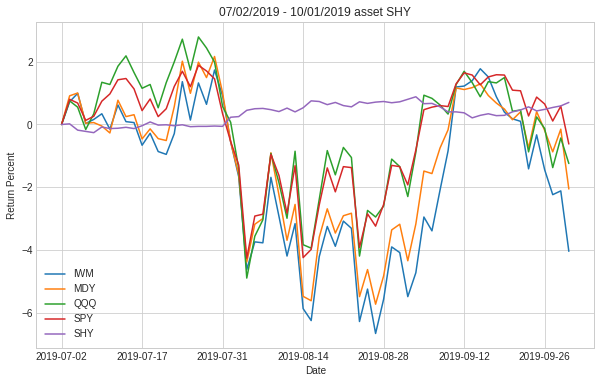

In [746]:
display_asset_selection('2019-10-01', asset_adj_close)

<p>
Although different ETFs are selected in some cases by the notebook code,
this difference may not be enough to account for the differences in the
trendlineprofits.com results and the notebook results.
</p>
<p>
As we can see from the trendlineprofits.com plots, the plots were generated
using the ETF simulation tools on ETFReplay.com.  The difference between
the results in this notebook and the results from ETFReplay.com may be due
to differences in the portfolio calculation.
</p>
<p>
I have written several versions of the portfolio calculation code.  I have
not been able to identify an error in the notebook code that would explain
the difference between the ETFReply.com results and the notebook.
</p>

In [747]:
def get_trendlineprofits_data(path: str) -> pd.DataFrame:
    """
    Return a composite DataFrame that is composed of period data built from the price time series
    and the Trendline Profits allocation data.  Here is an example:

       start_ix  start_date  end_ix    end_date equity bond
0      2789  2019-01-02    2809  2019-01-31    SHY  TLT
1      2810  2019-02-01    2828  2019-02-28    QQQ  TLT
2      2829  2019-03-01    2849  2019-03-29    QQQ  TLT
3      2850  2019-04-01    2870  2019-04-30    QQQ  JNK
4      2871  2019-05-01    2892  2019-05-31    QQQ  JNK
    """
    def read_trendlineprofits_data(file_path: str) -> pd.DataFrame:
        temp_file_path = Path(file_path)
        file_size = 0
        allocation_df = pd.DataFrame()
        if temp_file_path.exists():
            file_size = temp_file_path.stat().st_size
            if file_size > 0:
                allocation_df = pd.read_csv(file_path, index_col=False)
            else:
                print(f'Error: file at {file_path} has zero size')
        else:
            print(f'Error: Could not find file at location {file_path}')

        return allocation_df


    allocations_df = read_trendlineprofits_data(path)
    start_date_col = allocations_df.columns[0] # period start date
    end_date_col = allocations_df.columns[1]   # period end date
    asset_col = allocations_df.columns[2]     # equity ETF or SHY
    bond_col = allocations_df.columns[3]      # bond ETF
    num_rows = allocations_df.shape[0]
    first_row = allocations_df[:][0:1]
    last_row = allocations_df[:][num_rows - 1:num_rows]
    trend_start_date = first_row[start_date_col].values[0]
    trend_end_date = last_row[end_date_col].values[0]
    month_periods = find_month_periods(trend_start_date, trend_end_date, asset_adj_close)
    assert month_periods.shape[0] == num_rows
    composite_df = pd.concat([month_periods, allocations_df[asset_col], allocations_df[bond_col]], axis=1)
    return composite_df


trendlineprofits_data_path = 'data/trendlineprofits_assets.csv'
composite_df = get_trendlineprofits_data(trendlineprofits_data_path)
num_rows = composite_df.shape[0]
first_row = composite_df[:][0:1]
last_row = composite_df[:][num_rows - 1:num_rows]
trend_start_date = first_row['start_date'].values[0]
trend_end_date = last_row['end_date'].values[0]

trendline_portfolio_df = portfolio_replay(holdings=holdings,
                                          asset_percent=equity_percent,
                                          bond_percent=bond_percent,
                                          asset_etfs=asset_adj_close,
                                          bond_etfs=fixed_income_adjclose,
                                          etf_selection=composite_df)

notebook_portfolio_df, assets = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=trend_start_date,
                                              end_date=trend_end_date)

trendline_portfolio_df.columns = ['trendline']
notebook_portfolio_df.columns = ['notebook']
plot_df = build_plot_data(holdings, notebook_portfolio_df, spy_df)
plot_df = pd.concat([plot_df, trendline_portfolio_df], axis=1)

<p>
The first plot below shows the trendlineprofits.com ETF rotation strategy.  The second
plot compares SPY, the notebook portfolio and the results of a portfolio using the
trendlineprofits.com selected ETFs. This portfolio with the trendlineprofits.com ETF
set does not mirror the portfolio shown on their website. This suggests that the
difference is a result of the way the portfolios are calculated.
</p>

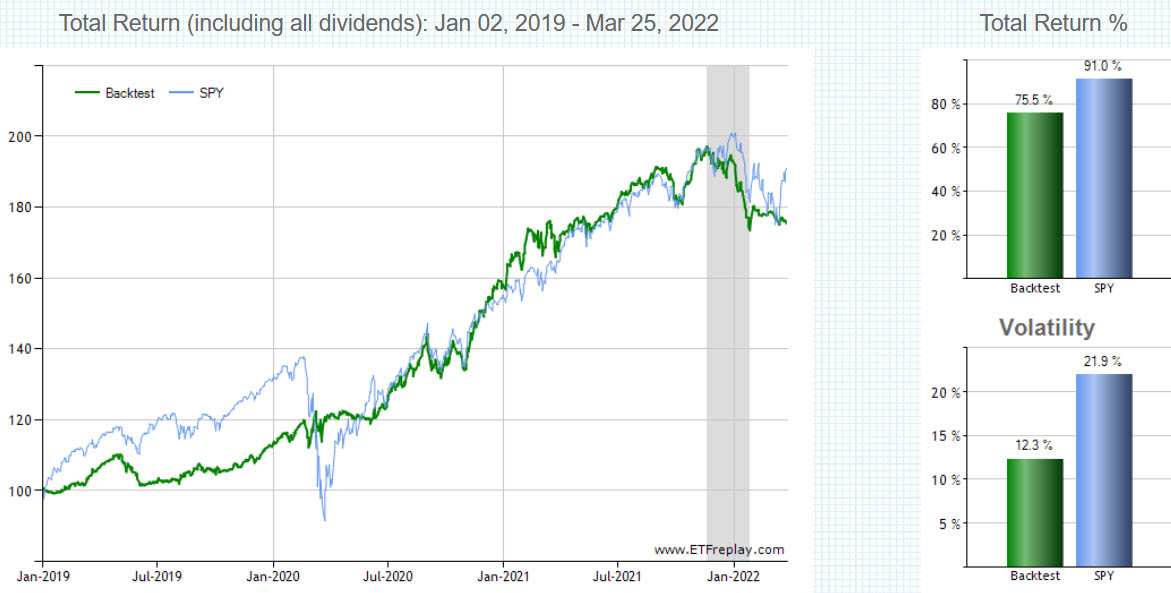

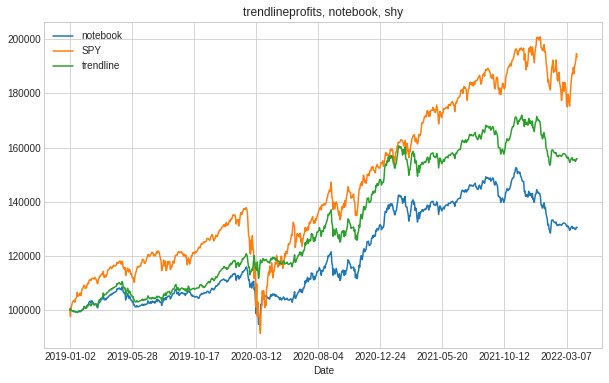

In [748]:
plot_df.plot(grid=True, title='trendlineprofits, notebook, shy', figsize=(10,6))
Image(filename='images/the-12-total-return-2019-to-ytd-03-25-2022_orig.jpg')

<h2>
Portfolio Variations
</h2>

<p>
In this section of the notebook I examine several variations on the
<i>12% Solution</i> portfolio using a different mix of assets.
</p>

<h3>
Adding SHY as a Bond Option
</h3>

<p>
In the question and answer section of the <i>12% Solution</i> the author is asked whether
adding SHY (the cash proxy ETF) to the bond rotation might produce better results.
He writes that in the backtests adding SHY did not improve the results.
However, the book's results end around 2018,
before COVID and the Russian invasion of Ukraine.  This section looks at whether
in this later period adding SHY to the bond set might produce better results.
</p>

In [749]:
fixed_income_plus_shy = pd.concat([fixed_income_adjclose, shy_adj_close], axis=1)
portfolio_bond_plus_shy_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_plus_shy,
                                              start_date=start_date,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, portfolio_bond_plus_shy_df, spy_df)

<p>
As reported in <i>The 12% Solution</i> including SHY in the bond set results in
slightly worse portfolio performance.
</p>

<AxesSubplot:title={'center':'Portfolio (bond + SHY) and SPY'}, xlabel='Date'>

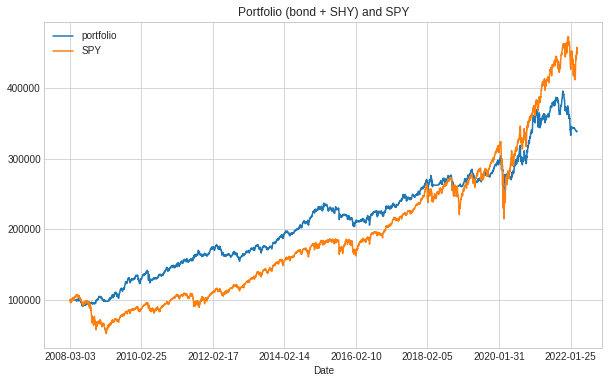

In [750]:
plot_df.plot(grid=True, title='Portfolio (bond + SHY) and SPY', figsize=(10,6))

<h3>
Results with SPY and Bond ETF Rotation
</h3>

<p>
The equity ETFs are all highly correlated (correlations
close to 1.0).  This section investigates the performance of an ETF rotation that
consists of SPY (the S&P 500 ETF) and SHY (the cash ETF), with bond
rotation between TLT and JNK.
</p>

<AxesSubplot:title={'center':'SPY/SHY Portfolio and SPY'}, xlabel='Date'>

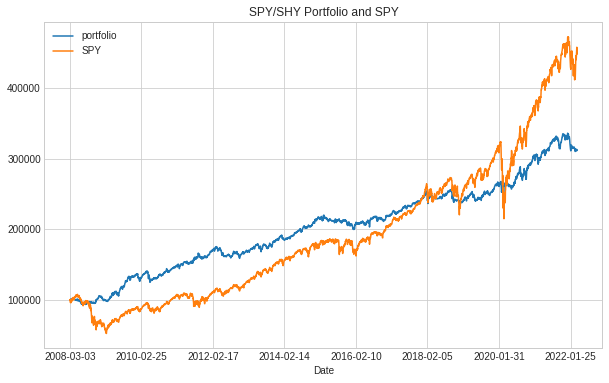

In [751]:
limited_asset_set_df = asset_adj_close[['SPY', 'SHY']]

portfolio_limited_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=limited_asset_set_df,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=start_date,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, portfolio_limited_df, spy_df)

plot_df.plot(grid=True, title='SPY/SHY Portfolio and SPY', figsize=(10,6))

<p>
The above plot shows that an equity portfolio that is just composed of only the SPY
and SHY ETFs has worse performance after 2018 than the complete ETF rotation set.  Although
the ETFs in the rotation set are highly correlated, there are periodic differences
in performance which may explain this result.
</p>

<h2>
Expanding the ETF Universe
</h2>

<p>
<i>The 12% Solution</i> is designed so that anyone who is willing
to spend a little bit of time every month can implement the investment strategy.
For readers who subscribe to the author's free email newsletter it is even simpler:
the current <i>12% solution</i> stock and bond recommendations are included. The
strategy only includes the four equity ETFs.
</p>
<p>
This section of the notebook investigates the ETF rotation results with an expanded
ETF universe.  Some of these assets are also in the <i>12% Solution</i> asset set.
</p>
<p>
The ETF universe is limited by the backtest start date of March 3, 2008 (2008-03-03).
The ETF inception date needs to be at least three trading months before this date
to provide sufficient history to select an ETF on the start date.
</p>

<h3>
Bond ETFs
</h3>

<ul>
<li>
<p>
SPIP - SPDR Portfolio TIPS ETF
</p>
<p>
Inception Date: 05/25/2007
</p>
</li>

<li>
<p>
BIV - Vanguard Intermediate-Term Bond ETF
</p>
<p>
Inception Date: 04/03/2007
</p>
</li>

<li>
<p>
IEF - iShares 7-10 Year Treasury Bond ETF
</p>
<p>
Inception Date: 07/22/2002
</p>
</li>

<li>
<p>
TLT - iShares 20+ Year Treasury Bond ETF (from <i>12% Solution</i>)
</p>
<p>
Inception Date: 07/22/2002
</p>
</li>

<li>
<p>
VYM - Vanguard High Dividend Yield ETF (replacement for JNK)
</p>
<p>
Inception Date: 11/10/2006
</p>
</li>

</ul>

<h3>
Equity ETFs
</h3>

<ul>
<li>
<p>
XLE - Energy Select Sector SPDR Fund
</p>
<p>
Inception Date: 12/16/1998
</p>
</li>

<li>
<p>
VUG - Vanguard Growth ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
VBR - Vanguard Small-Cap Value ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
FXZ - First Trust Materials AlphaDEX Fund
</p>
<p>
Inception Date: 05/08/2007
</p>
</li>

<li>
<p>
VDC - Vanguard Consumer Staples ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
MDY - SPDR S&P Midcap 400 ETF Trust
</p>
<p>
Inception Date: 05/04/1995
</p>
</li>

<li>
<p>
QQQ - Invesco QQQ Trust
</p>
<p>
Inception Date: 03/10/1999
</p>
</li>

<li>
<p>
VCR - Vanguard Consumer Discretionary ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
VFH - Vanguard Financials ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
VGT - Vanguard Information Technology ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
VHT - Vanguard Health Care ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
IWM - iShares Russell 2000 ETF
</p>
<p>
Inception Date: 05/22/2000
</p>
</li>

<li>
<p>
SPY - SPDR S&P 500 ETF Trust
</p>
<p>
Inception Date: 01/22/1993
</p>
</li>

<li>
<p>
SOXX - iShares Semiconductor ETF
</p>
<p>
Inception Date: 07/10/2001
</p>
</li>

</ul>

<h3>
Short Funds
</h3>

<p>
These ETFs take short positions against market indexes. They can be much more
volatile and, at least in the long term, risky than a standard long ETF.
</p>
<p>
The ETF rotation algorithm moves in and out of ETFs, so they are not held for a long
period of time, so the risk may be less.
</p>

<ul>

<li>
<p>
SDS - ProShares UltraShort S&P500
</p>
<p>
Inception Date: 07/11/2006
</p>
</li>

<li>
<p>
RWM - ProShares Short Russell 2000
</p>
<p>
Inception Date: 01/23/2007
</p>
</li>

</ul>

<p>
Data has already been downloaded for IWM, MDY, QQQ, SPY and TLT.
</p>

In [752]:
new_equity_etfs = ['XLE', 'VUG', 'VBR', 'FXZ',
                   'VDC', 'VCR', 'VFH', 'VGT',
                   'VHT', 'SOXX']

new_bond_etfs = ['SPIP', 'BIV', 'IEF', 'VYM']

short_etfs = ['SDS', 'RWM']

new_etf_adjclose_file = 'new_equity_etf_adjclose'
new_equity_adj_close = get_market_data(file_name=new_etf_adjclose_file,
                                data_col='Adj Close',
                                symbols=new_equity_etfs,
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

new_bond_adjclose_file = 'new_bond_etf_adjclose'
new_bond_adj_close = get_market_data(file_name=new_bond_adjclose_file,
                                data_col='Adj Close',
                                symbols=new_bond_etfs,
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

short_etf_adjclose_file = 'short_etf_adjclose'
short_etf_adj_close = get_market_data(file_name=short_etf_adjclose_file,
                                data_col='Adj Close',
                                symbols=short_etfs,
                                data_source=data_source,
                                start_date=look_back_date,
                                end_date=end_date)

new_etf_set = pd.concat([new_equity_adj_close, equity_adj_close, shy_adj_close], axis=1)
new_bond_set = pd.concat([new_bond_adj_close, fixed_income_adjclose['TLT']], axis=1)

portfolio_new_bond_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=new_bond_set,
                                              start_date=start_date,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, portfolio_new_bond_df, spy_df)

<h3>
ETF Rotation set with Expanded Bond ETFs
</h3>

<p>
In this backtest the equity ETF set is the same (the <i>12% Solution</i> set), but
the bond set is changed.
</p>

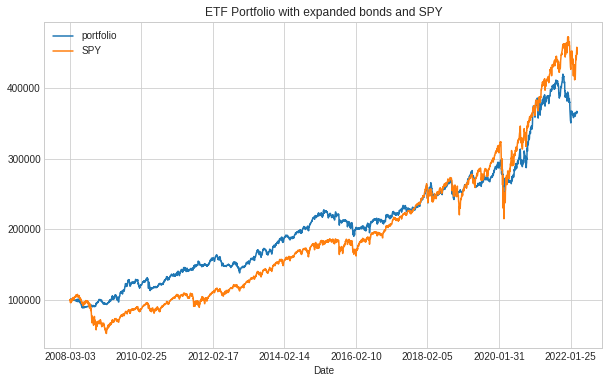

In [753]:

plot_df.plot(grid=True, title='ETF Portfolio with expanded bonds and SPY', figsize=(10,6))

portfolio_new_etf_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=new_etf_set,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=start_date,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, portfolio_new_etf_df, spy_df)

<h3>
Expanded ETF set with TLT/JNK
</h3>

<p>
In the plot below the new ETF set is used for the equity portion of the portfolio.
The bond portion consists of TLT/JNK as in previous portfolios.
</p>

<AxesSubplot:title={'center':'New ETF set with TLT/JNK and SPY'}, xlabel='Date'>

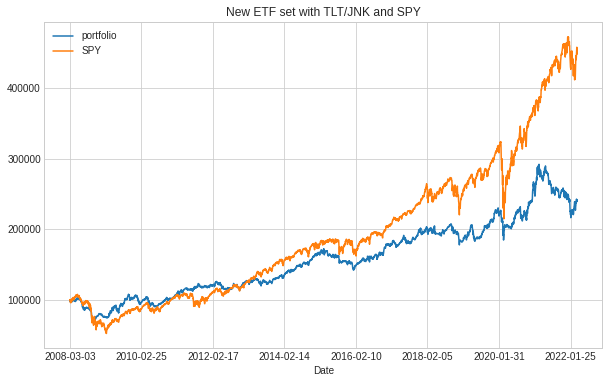

In [754]:
plot_df.plot(grid=True, title='New ETF set with TLT/JNK and SPY', figsize=(10,6))

<h3>
Expanded ETFs and Expanded Bonds
</h3>

<p>
The plot below show the ETF rotation portfolio with an expanded set of ETFs.  The
results are significantly worse than the base <i>12% Solution</i> portfolio.  Not only
is the terminal value of the portfolio less than the <i>12% Solution</i> portfolio, but
it also appears to be more volatile.
</p>

<AxesSubplot:title={'center':'Expanded ETF and Bonds and SPY'}, xlabel='Date'>

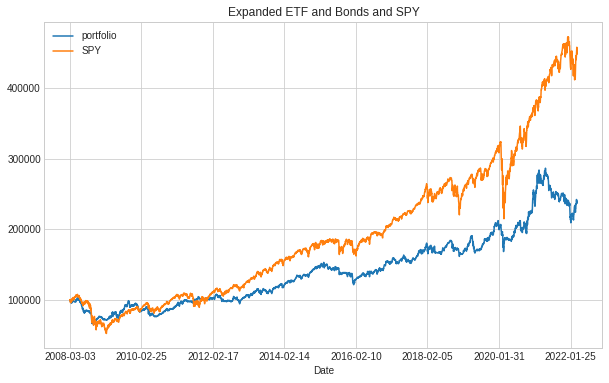

In [755]:
portfolio_all_new_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=new_etf_set,
                                              bond_etfs=new_bond_set,
                                              start_date=start_date,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, portfolio_all_new_df, spy_df)

plot_df.plot(grid=True, title='Expanded ETF and Bonds and SPY', figsize=(10,6))

<p>
The expanded ETF universe was chosen to provide broad coverage over a number of sectors.
The hope was that different sectors might have superior performance, even if this was
not the case over time. As these results demonstrate, this was not the case.
</p>

<h3>
The 12% Portfolio plus Market Short ETFs
</h3>

<p>
There are a number of ETFs that take a short position with respect to market indexes.
The idea behind these is seductive: in a market down period these ETFs will provide
better results when equity long ETFs lose money.  In theory the market short ETFs
should would only be chosen when the market as down.
</p>

In [756]:
assets_plus_short = pd.concat([asset_adj_close, short_etf_adj_close], axis=1)
portfolio_plus_short_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=assets_plus_short,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=start_date,
                                              end_date=end_date)

plot_df = build_plot_data(holdings, portfolio_plus_short_df, spy_df)

<p>
As the plot below shows, the ETF set that includes the market short ETFs have the worst
performance of any portfolio so far.
</p>
<p>
The ETF for the current month is chosen on the basis of the performance for the past
three months.  This is a momentum strategy and the market short ETFs seem to perform
very badly with this strategy. From these results we can assume that for the
 market short ETFs the returns in next month
are not highly correlated with the return over the past three months.
</p>

<AxesSubplot:title={'center':'Portfolio plus short ETFs and SPY'}, xlabel='Date'>

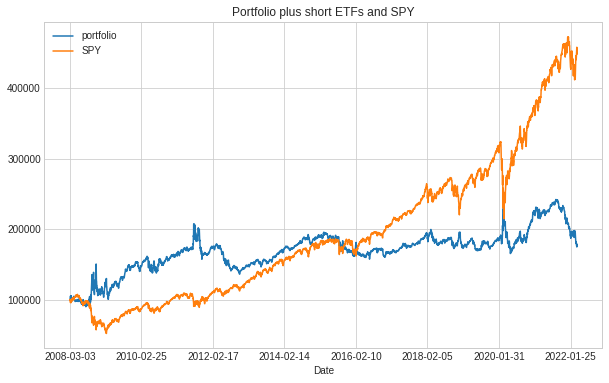

In [757]:
plot_df.plot(grid=True, title='Portfolio plus short ETFs and SPY', figsize=(10,6))

<h3>
Analyzing Momentum
</h3>
<p>
The results with the expanded ETF set and the short ETF set show much worse portfolio
performance than the results with <i>The 12% Portfolio</i>.  The results with the
short ETFs are particularly bad.
</p>
<p>
The momentum algorithm used in the ETF rotation portfolio depends on the prediction
of the next month's return based on the return over the previous three months.  If
the return in the last three months is positive, the return in the next month
should be positive.
</p>
<p>
In the case of the market short ETFS, the past three month return does
not appear to strongly predict the next month return.
</p>
<p>
In this section we examine the correlation statistical test to see if correlation
can be used to successfully select an ETF set that will result in superior
portfolio performance.
</p>

In [758]:
def calculate_return_series(close_prices_df: pd.DataFrame,
                            start_date: datetime) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    :param close_prices_df: a DataFrame of close prices where all of the data aligns on date
    :param start_date: the start date to use in calculating the returns
    :return: a Series with the past three month return and the return for the next month
    """
    date_index = close_prices_df.index
    end_date = date_index[-1]
    end_date_t = convert_date(end_date)
    back_delta = relativedelta(months=3)
    forward_delta = relativedelta(months=1)
    start_date_i = start_date
    three_month_return_df = pd.DataFrame()
    one_month_return_df = pd.DataFrame()
    while start_date_i <= end_date_t:
        # Start of the back-test data
        back_start = start_date_i - back_delta
        # End of the backtest data
        back_end = start_date_i
        # end of the forward data period (e.g., one month)
        forward_end = start_date_i + forward_delta
        start_ix = findDateIndex(date_index, back_start)
        end_ix = findDateIndex(date_index, back_end)
        forward_ix = findDateIndex(date_index, forward_end)
        if start_ix >= 0 and end_ix >= 0 and forward_ix >= 0:
            three_month_a = (close_prices_df[:][start_ix:start_ix+1].values / close_prices_df[:][end_ix:end_ix+1].values) - 1
            three_month_return_df = pd.concat([three_month_return_df, pd.DataFrame(three_month_a)])
            one_month_a = (close_prices_df[:][forward_ix:forward_ix+1].values / close_prices_df[:][end_ix:end_ix+1].values) - 1
            one_month_return_df = pd.concat([one_month_return_df, pd.DataFrame(one_month_a)])
        else:
            break
        start_date_i = forward_end
    three_month_return_df.columns = close_prices_df.columns
    one_month_return_df.columns = close_prices_df.columns
    return three_month_return_df, one_month_return_df


all_etf_adj_close = pd.concat([equity_adj_close,
                               new_equity_adj_close,
                               short_etf_adj_close,
                               shy_adj_close], axis=1)
corr_end_date = start_date + relativedelta(years=8)
date_index = all_etf_adj_close.index
corr_end_ix = findDateIndex(date_index, corr_end_date)
all_etf_adj_close_trunc = all_etf_adj_close[:][0:corr_end_ix+1]
three_month_df, one_month_df = calculate_return_series(close_prices_df=all_etf_adj_close_trunc, start_date=start_date)
return_corr = three_month_df.corrwith(one_month_df)
return_corr.sort_values(ascending=False, inplace=True)
return_corr_df = pd.DataFrame(return_corr)


<h3>
Correlation
</h3>

<p>
A correlation of 0 means that there is no correlation between the series.
A correlation of 1.0 means that the two time series are exactly correlated.
A correlation of -1 means that the two time series are exactly anti-correlated.
</p>
<p>
The table below shows the correlation between the three month return and the one
month return for the ETFs that hae been used in ETF rotations above.
</p>
<p>
When using correlation values to select ETFs it is important to make sure that
future information is never applied to past data, since this results in any
invalid backtest.
</p>
<p>
The correlation period goes from 2008 to eight years in the past from the
current day when the notebook is run.  This allows an eight year backtest
period that can use the correlation information.
</p>

In [759]:
print(tabulate(return_corr_df, headers=['Correlation'], tablefmt='fancy_grid'))

╒══════╤═══════════════╕
│      │   Correlation │
╞══════╪═══════════════╡
│ VDC  │    0.130485   │
├──────┼───────────────┤
│ VBR  │    0.12879    │
├──────┼───────────────┤
│ VCR  │    0.11757    │
├──────┼───────────────┤
│ IWM  │    0.110812   │
├──────┼───────────────┤
│ RWM  │    0.10458    │
├──────┼───────────────┤
│ SDS  │    0.0827703  │
├──────┼───────────────┤
│ VHT  │    0.0743858  │
├──────┼───────────────┤
│ FXZ  │    0.0614665  │
├──────┼───────────────┤
│ MDY  │    0.0331212  │
├──────┼───────────────┤
│ SPY  │    0.029719   │
├──────┼───────────────┤
│ VFH  │    0.0199856  │
├──────┼───────────────┤
│ XLE  │    0.0152139  │
├──────┼───────────────┤
│ QQQ  │    0.00815391 │
├──────┼───────────────┤
│ VGT  │   -0.0126166  │
├──────┼───────────────┤
│ VUG  │   -0.0140326  │
├──────┼───────────────┤
│ SHY  │   -0.0253275  │
├──────┼───────────────┤
│ SOXX │   -0.0317874  │
╘══════╧═══════════════╛


<p>
Arbitrarily choosing a correlation that is greater than 0.10, an ETF rotation set
is constructed.
</p>

In [760]:
etf_corr_set = return_corr_df[:][return_corr_df >= 0.10].dropna()
high_corr_etfs = all_etf_adj_close[etf_corr_set.index]
# make sure that SHY is included in the ETF set
if not 'SHY' in high_corr_etfs.columns:
    high_corr_etfs = pd.concat([high_corr_etfs, shy_adj_close], axis=1)

high_corr_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=high_corr_etfs,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=corr_end_date,
                                              end_date=end_date)

twelve_percent_df,  assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=corr_end_date,
                                              end_date=end_date)


spy_df_adj, t = adjust_time_series(spy_df, high_corr_portfolio_df)

plot_df = build_plot_data(holdings, high_corr_portfolio_df, spy_df_adj)
plot_df['twelve percent'] = twelve_percent_df
plot_df.columns = ['Correlation', 'SPY', 'twelve percent']

The plot below shows the results of the "high correlation" portfolio, The 12% portfolio
and SPY.  The performance of the high correlation portfolio is much worse than the
other two portfolios.

<AxesSubplot:title={'center':'High Correlation ETFs, 12% Portfolio and SPY'}, xlabel='Date'>

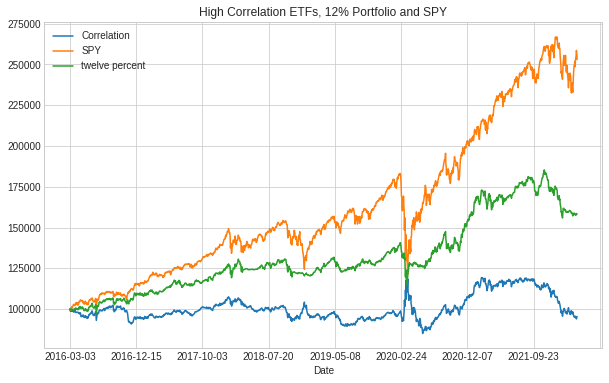

In [761]:
plot_df.plot(grid=True, title='High Correlation ETFs, 12% Portfolio and SPY', figsize=(10,6))

<h3>
Standard Error of the Correlation
</h3>

<p>
The ETF rotation algorithm is based on ETF momentum where the return in the current month
is predicted by the return in the previous three months.  The correlation between the
three month return and the one month return should be a measure of momentum.  An ETF
with a high correlation should perform better than an ETF with a low correlation.
</p>
<p>
This is not what we see in the previous plot, where the "high correlation" portfolio
performs much worse than the 12% portfolio or SPY.  A reason for this could be that the
correlation estimates contain so much error that in this case correlation is a
"garbage" statistic.
</p>
<p>
The correlation data used to select the "high correlation" ETF set contains 8 x 12 = 96
return values in eight year time period from March 2008 to
March 2016.
</p>
<p>
There is some controversy about the proper equation to use to calculate the standard
error of the correlation. For example, see this Stack Exchange
<a href="https://stats.stackexchange.com/questions/73621/standard-error-from-correlation-coefficient">post</a>.
</p>
<p>
Two equations are proposed for calculating the standard error of the correlation.
The results are very similar for the correlation values that are calculated here.
</p>

$\ Corr_{se} = \sqrt{ \frac{1 - r^2}{N-2} } \approx \frac{1 - r^2}{\sqrt{N}}$

<p>
Here <i>r</i> is the correlation coefficient.
</p>
<p>
The standard error values fall within a narrow range, so it is reasonable to take
the average value.
</p>

In [762]:
return_corr_a = return_corr.values
# https://stats.stackexchange.com/questions/73621/standard-error-from-correlation-coefficient
n = three_month_df.shape[0]
corr_se_1 = sqrt((1 - return_corr_a**2)/(n-2))
corr_se_2 = (1 - return_corr_a**2)/sqrt(n-2)

print(f'Correlation standard error: mean, equation 1 = {round(corr_se_1.mean(), 4)}, mean equation 2 = {round(corr_se_2.mean(), 4)}')

Correlation standard error: mean, equation 1 = 0.1023, mean equation 2 = 0.102


<p>
The standard error of the correlation is approximately
</p>

$ \mp 0.10$

<p>
This error is about the size of the top five correlation values, which suggests that
the correlation values cannot be relied on.
</p>

In [763]:

three_month_df, one_month_df = calculate_return_series(close_prices_df=all_etf_adj_close, start_date=start_date)
return_corr = three_month_df.corrwith(one_month_df)
return_corr.sort_values(ascending=False, inplace=True)
return_corr_df = pd.DataFrame(return_corr)

return_corr_a = return_corr.values
# https://stats.stackexchange.com/questions/73621/standard-error-from-correlation-coefficient
n = three_month_df.shape[0]
corr_se_1 = sqrt((1 - return_corr_a**2)/(n-2))
corr_se_2 = (1 - return_corr_a**2)/sqrt(n-2)

<h3>
ETF Correlations from 2008 to Present
</h3>

<p>
Many of the ETFs have an inception date in the third quarter of 2007.  Calculating
the three month and one month return correlation over this entire time period
yields a correlation with a smaller standard error.
</p>

In [764]:
print(tabulate(return_corr_df, headers=['Correlation'], tablefmt='fancy_grid'))

print('\n')
print(f'Number of returns used to calculate the correlations: {n}')

print(f'Correlation standard error: mean equation 1 = {round(corr_se_1.mean(), 4)}, mean equation 2 = {round(corr_se_2.mean(), 4)}')

╒══════╤═══════════════╕
│      │   Correlation │
╞══════╪═══════════════╡
│ VHT  │     0.175776  │
├──────┼───────────────┤
│ VCR  │     0.172003  │
├──────┼───────────────┤
│ VBR  │     0.161949  │
├──────┼───────────────┤
│ VDC  │     0.152768  │
├──────┼───────────────┤
│ IWM  │     0.15194   │
├──────┼───────────────┤
│ MDY  │     0.121656  │
├──────┼───────────────┤
│ SPY  │     0.110969  │
├──────┼───────────────┤
│ SDS  │     0.0991441 │
├──────┼───────────────┤
│ QQQ  │     0.0853499 │
├──────┼───────────────┤
│ VGT  │     0.0835835 │
├──────┼───────────────┤
│ VUG  │     0.0820569 │
├──────┼───────────────┤
│ FXZ  │     0.0794136 │
├──────┼───────────────┤
│ XLE  │     0.0729327 │
├──────┼───────────────┤
│ RWM  │     0.0718137 │
├──────┼───────────────┤
│ VFH  │     0.0440606 │
├──────┼───────────────┤
│ SOXX │     0.0227336 │
├──────┼───────────────┤
│ SHY  │    -0.233538  │
╘══════╧═══════════════╛


Number of returns used to calculate the correlations: 170
Correlation sta

<p>
A backtest attempts to simulate a result from some point in the past.  We cannot use
the more accurate correlation estimates in the backtest because we would not have had
these values in the past (in 2016, for example).
</p>
<p>
We could use the more accurate correlation values going forward from our current time,
but we don't know whether using a subset of the ETFs ranked by their correlation value
would yield better results.
</p>


<h2>
Discussion
</h2>

<h3>
Do Your Own Due Dilligence
</h3>

<p>
Investment discussions, including this one, advise the readers to "do
their own due dilligence" and investigate the topic themselves before investing.
</p>
<p>
<i>The 12% Solution</i> ETF rotation algorithm is conceptually simple. Evaluating how
this algorithm performs over various past periods turns out to be complicated.
Reproducing the results reported in the book and on the trendlineprofits.com website
would be time consuming using on-line tools like ETFReplay.com and StockCharts.com. The
portfolio calculation in ETFReplay.com is a "blackbox" so the user does not have
direct insight into how this calculation is performed.
</p>
<p>
This notebook explores the results reported in <i>The 12% Solution</i>. Developing
and testing the Python code in this notebook took many days. The effort required
to reproduce the investment results reported in <i>The 12% Solution</i>, either
using on-line tools or custom software like this notebook means that many
readers will not be able to verify the results for themselves.
In this case, the reader may be better off investing in a "buy and hold" portfolio like
the
<a href="https://github.com/IanLKaplan/all_weather_portfolio/blob/master/all_weather_portfolio.ipynb">
All Weather Portfolios</a>.
</p>
<p>
I have been unable to reproduce
the results reported in the book and on the trendlineprofits.com website. The results
in this notebook have lower returns than those reported in the book and on
trendlineprofits.com. Although I have spent considerable time looking for the
source of this difference, I have not succeeded in finding it.
</p>
<p>
The results shown in this notebook are transparent,
since the code to calculate the results is included in the notebook.
</p>

<h3>
Backtests
</h3>
<p>
The future cannot be known, so we must rely on the past to understand the possible
performance of an investment algorithm. Backtests, like those in this notebook and
in <i>The 12% Solution</i> provide a view of what would have happened if ETF
rotation was applied in the past.
</p>
<p>
Actual investment is virtually
always different from the results shown in backtests. The success of an investment
approach like ETF rotation would not be revealed for years, given the volatility
of the yearly returns we see in this notebook and in <i>The 12% Solution</i> book
and website.
</p>

<h3>
Continuously Compounded Returns vs. Monthly Returns
</h3>
<p>
The portfolio calculations are performed using simple daily returns (see the section
above on return calculation) which are compounded daily to produce the a smooth
time series for the plots.
</p>
<p>
If the ETF rotation algorithm were actually in actual investment, an ETF would be
purchased at the start of a month and sold at the end (if a new ETF were selected, otherwise
the ETF would be held). If the ETF is sold, the portfolio might be rebalanced.
When ETFs are purchased only full shares can be purchased.
</p>
<p>
The fact that real market trades do not use fractional shares and would use monthly
returns means that the actual results will differ from the simulated results.
</p>
<h3>
Past Performance Does Not Guarantee Future Performance
</h3>
<p>
The backtest period used in this notebook starts in 2008, which corresponds to the
financial crisis that was caused by massive speculation in low grade mortgage bonds.
The United States government and governments in Europe undertook a years long
period of "quantitative easing" to avoid a possible depression on the
level that was seen in the 1930s.
</p>
<p>
Quantitative easing is another term for expanding the money supply. This resulted
in interest rates near zero and very low bond returns. Investors moved money into
the stock market since bond returns were so unattractive.
</p>
<p>
The world wide COVID pandemic also resulted in a period of government spending
and low interest rates to support the Western economies.  As we can see from the
SPY market plots throughout this notebook, this resulted in significant market
returns, which were at the start of the pandemic not reflected in the overall
economy.
</p>
<p>
On February 24, 2022 Russia invaded Ukraine.  This made Russia a pariah state
that has been boycotted by Europe and the United States in many areas.  By blocking
Russian banking and, partially, oil and gas sales, oil and gas prices have
dramatically increased.
</p>
<p>
All of this means that the market returns from 2008 to 2022 may not continue.
For the first time since the mid-1970s, inflation has risen significantly,
driven by the increase in energy prices and supply chain disruptions caused by
the COVID pandemic. Bond prices will also rise. With an improvement in bond
returns, investor money will move from the stock market into bonds. The result
may be lower stock market returns.
</p>
<h3>
Correlation is not everything
</h3>
<p>
At the start of the notebook a correlation table is shown for the market ETFs
IWM, MDY, QQQ and SPY. These ETFs are strongly correlated so I did not expect
that the combination would result in better portfolio returns compared to any
single component. To explore this, the portfolio return of SPY and the bonds,
TLT and JNK, was explored.  A number of different ETF combinations were
explored as well.
</p>
<p>
None of these ETF combinations yielded better results than the ETF combination
recommended in <i>The 12% Solution</i>.  This has been a surprise to the author
suggesting that the correlation statistic must be used carefully.
</p>

In [765]:
since_2019_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=d2019_start,
                                              end_date=end_date)

plot_since_2019_df = build_plot_data(holdings, since_2019_portfolio_df, spy_df)



past_year_start = end_date - relativedelta(years=1)
past_year_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                              asset_percent=equity_percent,
                                              bond_percent=bond_percent,
                                              asset_etfs=asset_adj_close,
                                              bond_etfs=fixed_income_adjclose,
                                              start_date=past_year_start,
                                              end_date=end_date)

plot_one_df = build_plot_data(holdings, past_year_portfolio_df, spy_df)

<h3>
Is ETF Rotation a Good Investment Strategy
</h3>

<AxesSubplot:title={'center':'ETF Rotation 04/13/2021 - 04/13/2022 and SPY'}, xlabel='Date'>

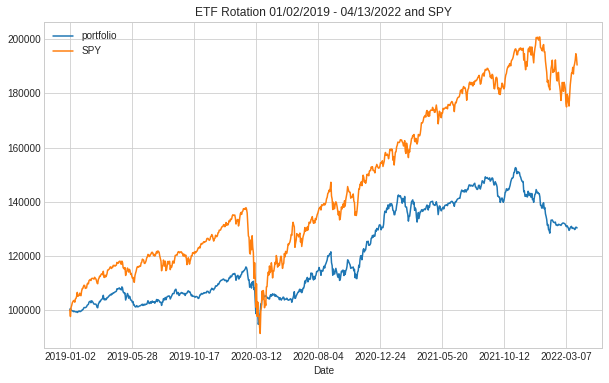

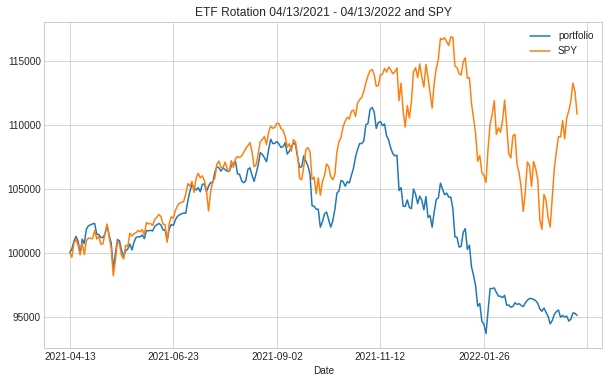

In [766]:
plot_since_2019_df.plot(grid=True, title=f'ETF Rotation {d2019_start.strftime("%m/%d/%Y")} - {end_date.strftime("%m/%d/%Y")} and SPY', figsize=(10,6))

plot_one_df.plot(grid=True, title=f'ETF Rotation {past_year_start.strftime("%m/%d/%Y")} - {end_date.strftime("%m/%d/%Y")} and SPY', figsize=(10,6))

<p>
The answer to whether the ETF rotation is a good investment strategy is: "it depends".
The attractiveness of an investment strategy depends on an investor's tolerance for
risk (portfolio losses). Risk tolerance is often related to the investor's time frame.
If the investor's time frame is measured in decades, the ETF rotation strategy is
probably a good choice since it will avoid many market downturns.  The years with
low or negative return will be offset by years with high return. The ETF rotation
portfolios also have lower risk.
</p>
<p>
If you invested in 2008 to 2019 the returns on ETF rotation equaled or exceeded the
S&P 500, with significantly less risk. As this notebook shows, the ETF rotation
strategy beat the S&P 500 because it avoided the 2008 market downturn.  If the
ETF rotation strategy were invested starting in 2010, the strategy would not
have beat the S&P 500.
</p>
<p>
The overall portfolio return of the ETF rotation strategy shown in this notebook
is even worse for a portfolio investment that starts in 2019,  although the volatility
is lower. This suggests that the investor should think carefully about investing with this
strategy.
</p>
<p>
Considering the ETF rotation portfolio since 2019 it might be better to choose
a dividend investment strategy (see <a href="https://github.com/IanLKaplan/all_weather_portfolio/blob/master/dividend_portfolio.ipynb">
Dividend Portfolios</a>) that returns at least 7%.
</p>
<p>
For those with a higher tolerance for risk, investing in a basket of ETFs may
provide better results. If, after all, you invest in market indexes, you will
get the market index return, which is not always true with ETF rotation.
</p>

<h2>
Disclaimer
</h2>
<p>
This notebook is not financial advice, investment advice, or tax advice.
The information in this notebook is for informational and recreational purposes only.
Investment products discussed (ETFs, mutual funds, etc.) are for illustrative purposes
only. This is not a recommendation to buy, sell, or otherwise transact in any of the
products mentioned. Do your own due diligence. Past performance does not guarantee
future returns.
</p>